In [706]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
from sklearn.metrics import confusion_matrix
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

- Clean notebook to be only new 
- Be able to merge train features and train targets
- same with test
- be able to then split and run program
- test for overfit
- create additional features (business/extra features from swing/ extra features from bugs)
- run reviews for NLP

In [247]:
list_of_file_names = glob.glob("./zip_2/*.csv")

In [248]:
read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
list_of_file_names_org = list_of_file_names

In [249]:
fail_list

[3]

In [250]:
for x in fail_list:
    del list_of_file_names[x]

In [251]:
list_of_file_names[23]

'./zip_2/Zip_MedianListingPricePerSqft_AllHomes.csv'

In [252]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [253]:
useful_df = build_useful_df(read_data_list_2)


In [254]:
sixteen_list = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)

In [255]:
len(sixteen_list)

30

In [256]:
good_columns = []
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)

In [257]:
sixteen_good = []
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [258]:
len(sixteen_good)

12

In [259]:
target_data = useful_df[23]

In [260]:
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [261]:
len(final_data_list[3])

10066

In [262]:
# Docs that don't need feature engineering. They are already aggregates
pure_features = [0, 71, 75, 77, 79, 81]
useful_df[0].head()

,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro
RegionName,,,,
99654,11.142857,82.0,9.230769,7.260083
99645,7.589286,74.0,0.769231,7.260083
99577,8.108108,79.5,4.615385,7.260083
99567,9.836066,76.0,2.307692,7.260083
99518,14.925373,85.0,10.000000,7.260083


In [263]:
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    return features
    

def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    

    
    return df_one, target




test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
train_features = train_features.append(train_features)
train_targets = train_targets.append(train_targets)







date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["06","12"]:
            new_time = year+"-"+month
            date_counter += 1
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

#### Have not worked on w2v today; focused on business

In [267]:
w2v_features = pd.read_csv('real_business_w2v_features_3_6')

In [268]:
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)

In [269]:
w2v_features.shape

(959, 512)

In [270]:
w2v_features.index = w2v_features['postal_code']

In [271]:
w2v_features = w2v_features.iloc[:, 1:]

In [272]:
w2v_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min,...,490,491,492,493,494,495,496,497,498,499
postal_code,,,,,,,,,,,,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0,...,-0.007905,-0.050745,0.019509,0.089886,-0.067859,-0.057686,-0.073559,0.004500,-0.062522,0.054272
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0,...,0.024744,0.024881,0.039596,0.043280,-0.032233,-0.017144,0.060047,-0.002217,0.063483,-0.041164
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0,...,-0.032312,-0.024693,-0.019165,0.015924,-0.044335,-0.020998,0.041530,-0.048317,0.086379,-0.008370
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0,...,-0.014649,0.000344,0.033006,-0.015937,0.011044,0.094979,0.085854,-0.037768,-0.038649,0.033392
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0,...,-0.013431,0.007048,0.017738,-0.013003,0.016217,0.083113,0.092610,-0.032904,-0.048000,0.023717


#### Here is where business is imported

In [273]:
business_features = pd.read_csv('real_business_features_3_4')

In [276]:
business_features.shape

(959, 11)

In [277]:
business_features['postal_code'] = business_features['postal_code'].astype(str)

In [279]:
business_features = business_features.set_index('postal_code')

In [280]:
business_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
postal_code,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0


In [281]:
train_features.shape

(66132, 120)

In [282]:
train_features = train_features.reset_index()

In [283]:
test_features = test_features.reset_index()

In [285]:
train_targets = train_targets.reset_index()

In [286]:
test_targets = test_targets.reset_index()

In [292]:
# Merging on index for train features and targets so it doesn't multiply 
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')

In [293]:
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')

In [296]:
train_merge = train_merge.set_index('RegionName_x')

In [297]:
test_merge = test_merge.set_index('RegionName_x')

In [298]:
train_merge.shape

(66132, 122)

In [300]:
business_features.shape

(959, 10)

In [302]:
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [303]:
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [304]:
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [305]:
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [306]:
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [307]:
nztmc = new_zillow_test_merge.columns
test_merge = new_zillow_test_merge.iloc[:, :-10]

In [308]:
new_zillow_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [309]:
train_merge = new_zillow_train_merge.iloc[:, :-10]

In [310]:
len(train_merge.columns)

122

In [311]:
len(test_merge.columns)

122

In [312]:
# This should have all instances of the train and test. 
business_train_merge.shape

(3996, 132)

In [313]:
w2v_train_merge.shape

(3996, 633)

In [315]:
train_merge = train_merge.drop('RegionName_y', 1)

In [316]:
test_merge = test_merge.drop('RegionName_y', 1)

In [317]:
train_merge.columns

Index(['mean_x', 'std_x', 'min_x', 'max_x', 'swing_x', 'change_x',
       'swing_pos_x', 'swing_big_x', 'swing_neg_x', 'swing_loss_big_x',
       ...
       'std_y', 'min_y', 'max_y', 'swing_y', 'change_y', 'swing_pos_y',
       'swing_big_y', 'swing_neg_y', 'swing_loss_big_y', 'target'],
      dtype='object', length=121)

In [318]:
train_merge.dropna(inplace=True)

In [319]:
test_merge.dropna(inplace=True)

In [320]:
train_merge.index.nunique()

326

In [321]:
test_merge.index.nunique()

331

In [322]:
business_train_merge.dropna(inplace=True)

In [323]:
business_test_merge.dropna(inplace=True)

In [324]:
w2v_train_merge.dropna(inplace=True)

In [325]:
w2v_test_merge.dropna(inplace=True)

In [326]:
w2v_train_merge.index.nunique()

326

In [327]:
w2v_test_merge.index.nunique()

331

In [331]:
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values

In [333]:
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features

In [332]:
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

In [337]:
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [338]:
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)

In [339]:
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)

In [340]:
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)

In [373]:
y_test.var()

0.0028560998107322942

In [486]:
print(y_train.mean())
print(y_train.min())
print(y_train.max())

1.03568676443
0.809566962437
1.32300764356


In [487]:
print(y_test.mean())
print(y_test.min())
print(y_test.max())

1.01812630226
0.833675690212
1.18704258259


In [532]:
def create_y_class_2(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    
    for y in y_list:
        if y <= .9:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .9 and y <= .97:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .97 and y < 1.03:
            y_3.append(1)
        else:
            y_3.append(0)
        if y >= 1.03 and y < 1.1:
            y_4.append(1)
        else:
            y_4.append(0)
        if y >= 1.1:
            y_5.append(1)
        else:
            y_5.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    return y_df

In [533]:
y_cat_train = create_y_class_2(y_train)

In [534]:
y_cat_test = create_y_class_2(y_test)

In [535]:
y_cat_train_w2v = create_y_class_2(y_train_w2v)

In [536]:
y_cat_test_w2v = create_y_class_2(y_test_w2v)

In [537]:
y_cat_train_business = create_y_class_2(y_train_business)

In [538]:
y_cat_test_business = create_y_class_2(y_test_business)

In [540]:
y_test_business.var()

0.0028560998107322942

In [354]:
# Hold overfit model for now
model = Sequential()
model.add(Dense(3000, input_shape=(110,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [738]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.005)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [739]:
model.fit(x=X_train, y=y_train, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 2.4648 - val_loss: 1.7106
Epoch 2/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.2855 - val_loss: 0.1537
Epoch 3/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.3109 - val_loss: 0.1096
Epoch 4/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.2574 - val_loss: 0.1539
Epoch 5/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.2579 - val_loss: 0.1283
Epoch 6/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.2167 - val_loss: 0.0970
Epoch 7/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.1962 - val_loss: 0.1111
Epoch 8/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.1968 - val_loss: 0.1375
Epoch 9/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.1932 - val_loss: 0.1611
Epoch 10/500
2839/

2839/2839 [==============================] - 0s 30us/step - loss: 0.0190 - val_loss: 0.0033
Epoch 79/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0191 - val_loss: 0.0030
Epoch 80/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0188 - val_loss: 0.0032
Epoch 81/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0188 - val_loss: 0.0041
Epoch 82/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0190 - val_loss: 0.0053
Epoch 83/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0206 - val_loss: 0.0064
Epoch 84/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0197 - val_loss: 0.0031
Epoch 85/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0172 - val_loss: 0.0027
Epoch 86/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0175 - val_loss: 0.0029
Epoch 87/500
2839/2839 [==============================] - 0s 28us/st

2839/2839 [==============================] - 0s 30us/step - loss: 0.0065 - val_loss: 0.0029
Epoch 156/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0063 - val_loss: 0.0027
Epoch 157/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0054 - val_loss: 0.0027
Epoch 158/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0051 - val_loss: 0.0027
Epoch 159/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0060 - val_loss: 0.0033
Epoch 160/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 161/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0051 - val_loss: 0.0026
Epoch 162/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0049 - val_loss: 0.0028
Epoch 163/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0053 - val_loss: 0.0027
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 35us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 233/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0026 - val_loss: 0.0030
Epoch 234/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 235/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0035
Epoch 236/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 237/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 238/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 239/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 240/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 28us/step - loss: 0.0018 - val_loss: 0.0053
Epoch 310/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0018 - val_loss: 0.0056
Epoch 311/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0016 - val_loss: 0.0046
Epoch 312/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0017 - val_loss: 0.0052
Epoch 313/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0018 - val_loss: 0.0070
Epoch 314/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0055
Epoch 315/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0057
Epoch 316/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0017 - val_loss: 0.0059
Epoch 317/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0060
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 30us/step - loss: 0.0019 - val_loss: 0.0072
Epoch 387/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0021 - val_loss: 0.0046
Epoch 388/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0017 - val_loss: 0.0060
Epoch 389/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0055
Epoch 390/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0017 - val_loss: 0.0063
Epoch 391/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0019 - val_loss: 0.0059
Epoch 392/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0018 - val_loss: 0.0041
Epoch 393/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0015 - val_loss: 0.0051
Epoch 394/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0016 - val_loss: 0.0053
Epoch 395/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0057
Epoch 464/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0047
Epoch 465/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0054
Epoch 466/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0069
Epoch 467/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 468/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 469/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0014 - val_loss: 0.0053
Epoch 470/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0015 - val_loss: 0.0080
Epoch 471/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0021 - val_loss: 0.0046
Epoch 472/500
2839/2839 [==============================] - 0

In [ ]:
plt.plot(zillow_model.history['loss'])
plt.plot(zillow_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [740]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.01)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [743]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0043
Epoch 2/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0055 - val_loss: 0.0088
Epoch 3/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0137 - val_loss: 0.0133
Epoch 4/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0160 - val_loss: 0.0030
Epoch 5/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 6/500
2839/2839 [==============================] - 0s 41us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 9/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0031
Epoch 10/500
2839

2839/2839 [==============================] - 0s 30us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 79/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 80/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0046 - val_loss: 0.0164
Epoch 81/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0922 - val_loss: 1.0088
Epoch 82/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.2131 - val_loss: 0.0246
Epoch 83/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0393 - val_loss: 0.0048
Epoch 84/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0087 - val_loss: 0.0030
Epoch 85/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0048 - val_loss: 0.0032
Epoch 86/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 87/500
2839/2839 [==============================] - 0s 29us/st

2839/2839 [==============================] - 0s 29us/step - loss: 0.1538 - val_loss: 0.2634
Epoch 156/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.2671 - val_loss: 0.2698
Epoch 157/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.2900 - val_loss: 0.8574
Epoch 158/500
2839/2839 [==============================] - 0s 32us/step - loss: 4.1008 - val_loss: 30.9265
Epoch 159/500
2839/2839 [==============================] - 0s 30us/step - loss: 37.3535 - val_loss: 24.0820
Epoch 160/500
2839/2839 [==============================] - 0s 30us/step - loss: 18.2658 - val_loss: 0.0029
Epoch 161/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0098 - val_loss: 0.0029
Epoch 162/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0082 - val_loss: 0.0029
Epoch 163/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0070 - val_loss: 0.0029
Epoch 164/500
2839/2839 [==============================]

2839/2839 [==============================] - 0s 28us/step - loss: 0.0046 - val_loss: 0.0037
Epoch 233/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0045 - val_loss: 0.0035
Epoch 234/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 235/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 236/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 237/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0038 - val_loss: 0.0031
Epoch 238/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0038 - val_loss: 0.0030
Epoch 239/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0040 - val_loss: 0.0029
Epoch 240/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0043 - val_loss: 0.0058
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 310/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 311/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 312/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 313/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 314/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 315/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 316/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 317/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0036 - val_loss: 0.0039
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 32us/step - loss: 0.0061 - val_loss: 0.0028
Epoch 387/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0053 - val_loss: 0.0026
Epoch 388/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.0048 - val_loss: 0.0027
Epoch 389/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0046 - val_loss: 0.0029
Epoch 390/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.0050 - val_loss: 0.0041
Epoch 391/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0085 - val_loss: 0.0236
Epoch 392/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0608 - val_loss: 0.4231
Epoch 393/500
2839/2839 [==============================] - 0s 30us/step - loss: 1.4826 - val_loss: 2.4886
Epoch 394/500
2839/2839 [==============================] - 0s 29us/step - loss: 2.7621 - val_loss: 0.0174
Epoch 395/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 35us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 464/500
2839/2839 [==============================] - 0s 49us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 465/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 466/500
2839/2839 [==============================] - 0s 39us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 467/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 468/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 469/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 470/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0047
Epoch 471/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0074 - val_loss: 0.0031
Epoch 472/500
2839/2839 [==============================] - 0

In [745]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [746]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 3.1253 - val_loss: 0.3215
Epoch 2/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.3927 - val_loss: 0.2637
Epoch 3/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.3240 - val_loss: 0.2399
Epoch 4/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2909 - val_loss: 0.1291
Epoch 5/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2447 - val_loss: 0.1072
Epoch 6/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.2297 - val_loss: 0.1186
Epoch 7/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2025 - val_loss: 0.2005
Epoch 8/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.2366 - val_loss: 0.2338
Epoch 9/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.2277 - val_loss: 0.1693
Epoch 10/500
2839/

2839/2839 [==============================] - 0s 62us/step - loss: 0.0405 - val_loss: 0.0397
Epoch 79/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0409 - val_loss: 0.0388
Epoch 80/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0398 - val_loss: 0.0345
Epoch 81/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0397 - val_loss: 0.0410
Epoch 82/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0402 - val_loss: 0.0232
Epoch 83/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0334 - val_loss: 0.0252
Epoch 84/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0347 - val_loss: 0.0287
Epoch 85/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0369 - val_loss: 0.0343
Epoch 86/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0397 - val_loss: 0.0283
Epoch 87/500
2839/2839 [==============================] - 0s 62us/st

2839/2839 [==============================] - 0s 74us/step - loss: 0.0199 - val_loss: 0.0030
Epoch 156/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0184 - val_loss: 0.0029
Epoch 157/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0193 - val_loss: 0.0029
Epoch 158/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0183 - val_loss: 0.0029
Epoch 159/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0184 - val_loss: 0.0027
Epoch 160/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0198 - val_loss: 0.0031
Epoch 161/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.0197 - val_loss: 0.0031
Epoch 162/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0185 - val_loss: 0.0030
Epoch 163/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0189 - val_loss: 0.0029
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 64us/step - loss: 0.0113 - val_loss: 0.0027
Epoch 233/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0109 - val_loss: 0.0033
Epoch 234/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0121 - val_loss: 0.0030
Epoch 235/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0109 - val_loss: 0.0028
Epoch 236/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0109 - val_loss: 0.0030
Epoch 237/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0120 - val_loss: 0.0031
Epoch 238/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0111 - val_loss: 0.0029
Epoch 239/500
2839/2839 [==============================] - 0s 84us/step - loss: 0.0109 - val_loss: 0.0029
Epoch 240/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0102 - val_loss: 0.0034
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 78us/step - loss: 0.0067 - val_loss: 0.0026
Epoch 310/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0069 - val_loss: 0.0028
Epoch 311/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0067 - val_loss: 0.0027
Epoch 312/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0069 - val_loss: 0.0025
Epoch 313/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0063 - val_loss: 0.0027
Epoch 314/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0068 - val_loss: 0.0028
Epoch 315/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0067 - val_loss: 0.0025
Epoch 316/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 317/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0063 - val_loss: 0.0031
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 62us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 387/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0040 - val_loss: 0.0024
Epoch 388/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0045 - val_loss: 0.0026
Epoch 389/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.0043 - val_loss: 0.0023
Epoch 390/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0039 - val_loss: 0.0023
Epoch 391/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0039 - val_loss: 0.0023
Epoch 392/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 393/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 394/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 395/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 73us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 464/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 465/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 466/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 467/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 468/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 469/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 470/500
2839/2839 [==============================] - 0s 83us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 471/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 472/500
2839/2839 [==============================] - 0

In [730]:
def model_metrics(predictions, y_test):
    df = pd.DataFrame(predictions)
    # predicting a loss 3% or larger by seeing if max loss probability is higher then slight gain
    df['loss'] = np.where(df[0] > df[3], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then slight loss
    df['gain'] = np.where(df[4] > df[1], 1, 0)
    df = pd.merge(df, y_test, left_index=True, right_index=True, how='inner')
    # predicting a loss 3% or larger by seeing if max loss probability is higher then mean probibility 
    df['loss_large'] = np.where(df[0] > df[2], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then mean probibility 
    df['gain_large'] = np.where(df[4] > df[2], 1, 0)
    # Cheching if loss is predicted and a loss of 3% or more occurs
    df['loss_true_true'] = np.where((df['loss'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Checking if loss is predicted and price stays at the mean
    df['loss_stay'] = np.where((df['loss'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large loss is predicted and a loss of 3% or more occurs
    df['loss_large_true'] = np.where((df['loss_large'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Cheching if large loss is predicted and price stays at the mean
    df['loss_large_stay'] = np.where((df['loss_large'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if gain is predicted and a loss of 3% or more occurs
    df['gain_true_true'] = np.where((df['gain'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Checking if gain is predicted and price stays at the mean
    df['gain_stay'] = np.where((df['gain'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large gain is predicted and a gain of 3% or more occurs
    df['gain_large_true'] = np.where((df['gain_large'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Cheching if large gain is predicted and price stays at the mean
    df['gain_large_stay'] = np.where((df['gain_large'] == 1) & (df['3'] == 1), 1, 0)
    #df['gain_large_large'] = np.where((df['gain_large'] == 1) & (df['5'] == 1), 1, 0)
    # Checking if both loss and gain are selected. This appears to mean high volitility
    df['volitile'] = np.where((df['loss'] == 1) & (df['gain'] == 1), 1, 0)
    
    
    gain_pred = df['gain'].sum()
    gain_large_pred = df['gain_large'].sum()
    
    gain_stay_true = (df['gain_true_true'].sum() + df['gain_stay'].sum()) / df['gain'].sum()
    
    gain_true = df['gain_true_true'].sum() / df['gain'].sum()
    loss_stay_true = (df['loss_true_true'].sum() + df['loss_stay'].sum()) / df['loss'].sum()
    loss_stay_true = df['loss_true_true'].sum() / df['loss'].sum()
    gain_stay_large_true = (df['gain_large_true'].sum() + df['gain_large_stay'].sum()) / df['gain_large'].sum()
    gain_large_true = df['gain_large_true'].sum() / df['gain_large'].sum()
    loss_stay_large_true = (df['loss_large_true'].sum() + df['loss_large_stay']) / df['loss_large'].sum()
    loss_large_true = df['loss_large_true'].sum() / df['loss_large'].sum()
    volitile = df['volitile'].sum()
    print(gain_pred)
    print(gain_true)
    print(gain_stay_true)
    print(gain_large_pred)
    print(gain_large_true)
    print(gain_stay_large_true)
    
    

In [752]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [753]:
zillow_model = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 1.6097 - acc: 0.2843 - val_loss: 1.6527 - val_acc: 0.1511
Epoch 2/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.6000 - acc: 0.2931 - val_loss: 1.6506 - val_acc: 0.1541
Epoch 3/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.6074 - acc: 0.2864 - val_loss: 1.6488 - val_acc: 0.1662
Epoch 4/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5984 - acc: 0.3008 - val_loss: 1.6471 - val_acc: 0.1692
Epoch 5/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.6178 - acc: 0.2892 - val_loss: 1.6456 - val_acc: 0.1722
Epoch 6/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.6057 - acc: 0.2987 - val_loss: 1.6443 - val_acc: 0.1752
Epoch 7/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5995 - acc: 0.2892 - val_loss: 1.6430 - val_acc: 0.1782
Ep

Epoch 61/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5618 - acc: 0.3269 - val_loss: 1.5947 - val_acc: 0.3142
Epoch 62/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5619 - acc: 0.3300 - val_loss: 1.5939 - val_acc: 0.3142
Epoch 63/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5592 - acc: 0.3315 - val_loss: 1.5932 - val_acc: 0.3142
Epoch 64/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5533 - acc: 0.3318 - val_loss: 1.5924 - val_acc: 0.3142
Epoch 65/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5605 - acc: 0.3117 - val_loss: 1.5917 - val_acc: 0.3142
Epoch 66/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5601 - acc: 0.3297 - val_loss: 1.5909 - val_acc: 0.3142
Epoch 67/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5491 - acc: 0.3353 - val_loss: 1.5901 - val_acc: 0.3142
Epoch 68/500
2839/2839 [=================

Epoch 121/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5244 - acc: 0.3533 - val_loss: 1.5533 - val_acc: 0.3293
Epoch 122/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5235 - acc: 0.3410 - val_loss: 1.5527 - val_acc: 0.3293
Epoch 123/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5215 - acc: 0.3364 - val_loss: 1.5521 - val_acc: 0.3293
Epoch 124/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.5240 - acc: 0.3406 - val_loss: 1.5515 - val_acc: 0.3293
Epoch 125/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5170 - acc: 0.3529 - val_loss: 1.5509 - val_acc: 0.3293
Epoch 126/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5168 - acc: 0.3512 - val_loss: 1.5503 - val_acc: 0.3293
Epoch 127/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5201 - acc: 0.3420 - val_loss: 1.5496 - val_acc: 0.3293
Epoch 128/500
2839/2839 [=========

Epoch 181/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4962 - acc: 0.3473 - val_loss: 1.5180 - val_acc: 0.3263
Epoch 182/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.4967 - acc: 0.3565 - val_loss: 1.5174 - val_acc: 0.3263
Epoch 183/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4852 - acc: 0.3674 - val_loss: 1.5169 - val_acc: 0.3263
Epoch 184/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4870 - acc: 0.3681 - val_loss: 1.5163 - val_acc: 0.3263
Epoch 185/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.4845 - acc: 0.3681 - val_loss: 1.5158 - val_acc: 0.3263
Epoch 186/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.4815 - acc: 0.3843 - val_loss: 1.5152 - val_acc: 0.3263
Epoch 187/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.4756 - acc: 0.3765 - val_loss: 1.5146 - val_acc: 0.3263
Epoch 188/500
2839/2839 [=========

Epoch 241/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4652 - acc: 0.3797 - val_loss: 1.4853 - val_acc: 0.3293
Epoch 242/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.4619 - acc: 0.3825 - val_loss: 1.4847 - val_acc: 0.3293
Epoch 243/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4480 - acc: 0.3896 - val_loss: 1.4842 - val_acc: 0.3293
Epoch 244/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4502 - acc: 0.3892 - val_loss: 1.4837 - val_acc: 0.3293
Epoch 245/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4606 - acc: 0.3818 - val_loss: 1.4831 - val_acc: 0.3293
Epoch 246/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4633 - acc: 0.3755 - val_loss: 1.4827 - val_acc: 0.3293
Epoch 247/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4659 - acc: 0.3755 - val_loss: 1.4823 - val_acc: 0.3293
Epoch 248/500
2839/2839 [=========

Epoch 301/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4343 - acc: 0.3882 - val_loss: 1.4566 - val_acc: 0.3384
Epoch 302/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4336 - acc: 0.3857 - val_loss: 1.4561 - val_acc: 0.3384
Epoch 303/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4354 - acc: 0.3815 - val_loss: 1.4556 - val_acc: 0.3384
Epoch 304/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.4365 - acc: 0.3913 - val_loss: 1.4552 - val_acc: 0.3414
Epoch 305/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.4324 - acc: 0.3931 - val_loss: 1.4548 - val_acc: 0.3414
Epoch 306/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.4351 - acc: 0.3938 - val_loss: 1.4543 - val_acc: 0.3414
Epoch 307/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4149 - acc: 0.4030 - val_loss: 1.4539 - val_acc: 0.3414
Epoch 308/500
2839/2839 [=========

Epoch 361/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4100 - acc: 0.3952 - val_loss: 1.4317 - val_acc: 0.3505
Epoch 362/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4175 - acc: 0.3963 - val_loss: 1.4313 - val_acc: 0.3505
Epoch 363/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4121 - acc: 0.3808 - val_loss: 1.4310 - val_acc: 0.3505
Epoch 364/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4244 - acc: 0.3889 - val_loss: 1.4305 - val_acc: 0.3505
Epoch 365/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4210 - acc: 0.3853 - val_loss: 1.4303 - val_acc: 0.3505
Epoch 366/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4115 - acc: 0.3934 - val_loss: 1.4299 - val_acc: 0.3505
Epoch 367/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4215 - acc: 0.3783 - val_loss: 1.4295 - val_acc: 0.3505
Epoch 368/500
2839/2839 [=========

Epoch 421/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.3891 - acc: 0.4037 - val_loss: 1.4100 - val_acc: 0.3686
Epoch 422/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.3853 - acc: 0.4005 - val_loss: 1.4097 - val_acc: 0.3686
Epoch 423/500
2839/2839 [==============================] - 0s 33us/step - loss: 1.3987 - acc: 0.3868 - val_loss: 1.4093 - val_acc: 0.3686
Epoch 424/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.4042 - acc: 0.3910 - val_loss: 1.4090 - val_acc: 0.3686
Epoch 425/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3947 - acc: 0.3994 - val_loss: 1.4085 - val_acc: 0.3686
Epoch 426/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3861 - acc: 0.4065 - val_loss: 1.4081 - val_acc: 0.3716
Epoch 427/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3992 - acc: 0.3920 - val_loss: 1.4079 - val_acc: 0.3716
Epoch 428/500
2839/2839 [=========

Epoch 481/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3716 - acc: 0.3934 - val_loss: 1.3921 - val_acc: 0.3927
Epoch 482/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.3717 - acc: 0.4030 - val_loss: 1.3917 - val_acc: 0.3927
Epoch 483/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.3856 - acc: 0.3882 - val_loss: 1.3916 - val_acc: 0.3958
Epoch 484/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.3911 - acc: 0.3980 - val_loss: 1.3912 - val_acc: 0.3988
Epoch 485/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3922 - acc: 0.4015 - val_loss: 1.3910 - val_acc: 0.4018
Epoch 486/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3643 - acc: 0.4195 - val_loss: 1.3906 - val_acc: 0.3988
Epoch 487/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.3797 - acc: 0.4082 - val_loss: 1.3902 - val_acc: 0.3988
Epoch 488/500
2839/2839 [=========

In [754]:
predictions = model.predict(X_test)
model_metrics(predictions, y_cat_test)

ZeroDivisionError: division by zero

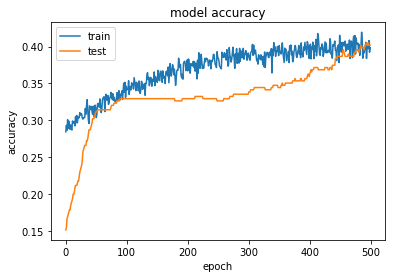

In [755]:
plt.plot(zillow_model.history['acc'])
plt.plot(zillow_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [756]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [748]:
business_model = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=500, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 1.4290 - acc: 0.3459 - val_loss: 1.2957 - val_acc: 0.4381
Epoch 2/500
2839/2839 [==============================] - 0s 38us/step - loss: 1.3392 - acc: 0.3843 - val_loss: 1.2893 - val_acc: 0.4350
Epoch 3/500
2839/2839 [==============================] - 0s 37us/step - loss: 1.3316 - acc: 0.3681 - val_loss: 1.2717 - val_acc: 0.4350
Epoch 4/500
2839/2839 [==============================] - 0s 37us/step - loss: 1.3060 - acc: 0.4037 - val_loss: 1.2706 - val_acc: 0.4411
Epoch 5/500
2839/2839 [==============================] - 0s 39us/step - loss: 1.3118 - acc: 0.3949 - val_loss: 1.2661 - val_acc: 0.4864
Epoch 6/500
2839/2839 [==============================] - 0s 37us/step - loss: 1.2875 - acc: 0.3942 - val_loss: 1.2614 - val_acc: 0.5166
Epoch 7/500
2839/2839 [==============================] - 0s 36us/step - loss: 1.2731 - acc: 0.4068 - val_loss: 1.2410 - val_acc: 0.4018
Ep

2839/2839 [==============================] - 0s 34us/step - loss: 0.9959 - acc: 0.5703 - val_loss: 1.0619 - val_acc: 0.5257
Epoch 61/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.9782 - acc: 0.5685 - val_loss: 1.0434 - val_acc: 0.5710
Epoch 62/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.9787 - acc: 0.5583 - val_loss: 1.0503 - val_acc: 0.5347
Epoch 63/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.9731 - acc: 0.5456 - val_loss: 1.0445 - val_acc: 0.5347
Epoch 64/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.9706 - acc: 0.5586 - val_loss: 1.0513 - val_acc: 0.5498
Epoch 65/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.9804 - acc: 0.5646 - val_loss: 1.1046 - val_acc: 0.5559
Epoch 66/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.9955 - acc: 0.5530 - val_loss: 1.0512 - val_acc: 0.5559
Epoch 67/500
2839/2839 [==============================

Epoch 120/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.7869 - acc: 0.6573 - val_loss: 1.1423 - val_acc: 0.5287
Epoch 121/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.8142 - acc: 0.6407 - val_loss: 1.1733 - val_acc: 0.4804
Epoch 122/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.7968 - acc: 0.6527 - val_loss: 1.2293 - val_acc: 0.4955
Epoch 123/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.7976 - acc: 0.6432 - val_loss: 1.2256 - val_acc: 0.4713
Epoch 124/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.7901 - acc: 0.6467 - val_loss: 1.2517 - val_acc: 0.4773
Epoch 125/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.8121 - acc: 0.6365 - val_loss: 1.1806 - val_acc: 0.5227
Epoch 126/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.7822 - acc: 0.6562 - val_loss: 1.1929 - val_acc: 0.4683
Epoch 127/500
2839/2839 [=========

2839/2839 [==============================] - 0s 35us/step - loss: 0.6512 - acc: 0.7365 - val_loss: 1.5082 - val_acc: 0.5166
Epoch 180/500
2839/2839 [==============================] - ETA: 0s - loss: 0.6910 - acc: 0.701 - 0s 34us/step - loss: 0.6917 - acc: 0.7006 - val_loss: 1.4592 - val_acc: 0.4683
Epoch 181/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.6584 - acc: 0.7298 - val_loss: 1.5202 - val_acc: 0.4562
Epoch 182/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.6761 - acc: 0.7119 - val_loss: 1.5799 - val_acc: 0.4592
Epoch 183/500
2839/2839 [==============================] - ETA: 0s - loss: 0.7262 - acc: 0.690 - 0s 35us/step - loss: 0.7111 - acc: 0.6950 - val_loss: 1.4676 - val_acc: 0.4653
Epoch 184/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.6418 - acc: 0.7337 - val_loss: 1.5826 - val_acc: 0.4532
Epoch 185/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.6877 - acc: 0.7038 - val_los

2839/2839 [==============================] - 0s 35us/step - loss: 0.5731 - acc: 0.7710 - val_loss: 1.6678 - val_acc: 0.4743
Epoch 238/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.5790 - acc: 0.7534 - val_loss: 1.6972 - val_acc: 0.4864
Epoch 239/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.5379 - acc: 0.7784 - val_loss: 1.7629 - val_acc: 0.4592
Epoch 240/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.6028 - acc: 0.7429 - val_loss: 1.6471 - val_acc: 0.4743
Epoch 241/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.5423 - acc: 0.7799 - val_loss: 1.7624 - val_acc: 0.4834
Epoch 242/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.5592 - acc: 0.7679 - val_loss: 1.8137 - val_acc: 0.4743
Epoch 243/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.5724 - acc: 0.7612 - val_loss: 1.9258 - val_acc: 0.4381
Epoch 244/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 35us/step - loss: 0.5073 - acc: 0.7876 - val_loss: 2.1117 - val_acc: 0.4804
Epoch 296/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.4749 - acc: 0.8070 - val_loss: 1.9856 - val_acc: 0.4562
Epoch 297/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.5442 - acc: 0.7732 - val_loss: 1.9450 - val_acc: 0.4743
Epoch 298/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.4648 - acc: 0.8108 - val_loss: 2.2572 - val_acc: 0.4864
Epoch 299/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.4684 - acc: 0.8035 - val_loss: 1.9793 - val_acc: 0.4834
Epoch 300/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4743 - acc: 0.8186 - val_loss: 1.9990 - val_acc: 0.4955
Epoch 301/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.4738 - acc: 0.8126 - val_loss: 1.9763 - val_acc: 0.4834
Epoch 302/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 34us/step - loss: 0.4690 - acc: 0.8035 - val_loss: 2.3934 - val_acc: 0.4532
Epoch 354/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4403 - acc: 0.8253 - val_loss: 2.4045 - val_acc: 0.4955
Epoch 355/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4113 - acc: 0.8380 - val_loss: 2.4842 - val_acc: 0.4743
Epoch 356/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4458 - acc: 0.8147 - val_loss: 2.6003 - val_acc: 0.4350
Epoch 357/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4368 - acc: 0.8242 - val_loss: 2.6003 - val_acc: 0.4894
Epoch 358/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4215 - acc: 0.8309 - val_loss: 2.3758 - val_acc: 0.4592
Epoch 359/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4430 - acc: 0.8207 - val_loss: 2.3059 - val_acc: 0.4502
Epoch 360/500
2839/2839 [=======================

Epoch 412/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.4424 - acc: 0.8309 - val_loss: 2.4440 - val_acc: 0.4471
Epoch 413/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.3412 - acc: 0.8640 - val_loss: 2.6911 - val_acc: 0.4502
Epoch 414/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.3358 - acc: 0.8725 - val_loss: 2.7396 - val_acc: 0.4683
Epoch 415/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.4088 - acc: 0.8341 - val_loss: 2.7003 - val_acc: 0.4562
Epoch 416/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.3758 - acc: 0.8521 - val_loss: 2.6908 - val_acc: 0.4743
Epoch 417/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.3728 - acc: 0.8499 - val_loss: 2.6238 - val_acc: 0.4924
Epoch 418/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.3354 - acc: 0.8679 - val_loss: 2.6340 - val_acc: 0.4532
Epoch 419/500
2839/2839 [=========

2839/2839 [==============================] - 0s 36us/step - loss: 0.3879 - acc: 0.8538 - val_loss: 3.0445 - val_acc: 0.4320
Epoch 472/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.3153 - acc: 0.8739 - val_loss: 3.0828 - val_acc: 0.4471
Epoch 473/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.3792 - acc: 0.8433 - val_loss: 2.8598 - val_acc: 0.4441
Epoch 474/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.3355 - acc: 0.8686 - val_loss: 3.0126 - val_acc: 0.4532
Epoch 475/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.3258 - acc: 0.8672 - val_loss: 2.9231 - val_acc: 0.4683
Epoch 476/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.2952 - acc: 0.8813 - val_loss: 3.1327 - val_acc: 0.4562
Epoch 477/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.3278 - acc: 0.8697 - val_loss: 3.1295 - val_acc: 0.4562
Epoch 478/500
2839/2839 [=======================

In [749]:
predictions = model.predict(X_test_business)
model_metrics(predictions, y_cat_test_business)

108
0.6666666666666666
0.9351851851851852
52
0.6923076923076923
0.9038461538461539


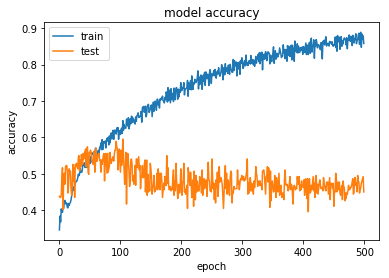

In [750]:
plt.plot(business_model.history['acc'])
plt.plot(business_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [757]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [758]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=500, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 2ms/step - loss: 1.4900 - acc: 0.3484 - val_loss: 1.3558 - val_acc: 0.4169
Epoch 2/500
2839/2839 [==============================] - 0s 69us/step - loss: 1.3637 - acc: 0.3801 - val_loss: 1.3214 - val_acc: 0.4139
Epoch 3/500
2839/2839 [==============================] - 0s 72us/step - loss: 1.3493 - acc: 0.3829 - val_loss: 1.2997 - val_acc: 0.4230
Epoch 4/500
2839/2839 [==============================] - 0s 70us/step - loss: 1.3231 - acc: 0.3949 - val_loss: 1.2724 - val_acc: 0.4441
Epoch 5/500
2839/2839 [==============================] - 0s 72us/step - loss: 1.3106 - acc: 0.4061 - val_loss: 1.2684 - val_acc: 0.4743
Epoch 6/500
2839/2839 [==============================] - 0s 71us/step - loss: 1.2948 - acc: 0.4111 - val_loss: 1.2590 - val_acc: 0.4048
Epoch 7/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.2798 - acc: 0.4139 - val_loss: 1.2230 - val_acc: 0.5045
Ep

2839/2839 [==============================] - 0s 71us/step - loss: 1.0500 - acc: 0.5382 - val_loss: 1.1189 - val_acc: 0.5227
Epoch 61/500
2839/2839 [==============================] - 0s 68us/step - loss: 1.0330 - acc: 0.5410 - val_loss: 1.1342 - val_acc: 0.5166
Epoch 62/500
2839/2839 [==============================] - 0s 70us/step - loss: 1.0060 - acc: 0.5488 - val_loss: 1.1736 - val_acc: 0.4713
Epoch 63/500
2839/2839 [==============================] - 0s 69us/step - loss: 1.0310 - acc: 0.5245 - val_loss: 1.1167 - val_acc: 0.4924
Epoch 64/500
2839/2839 [==============================] - 0s 71us/step - loss: 1.0152 - acc: 0.5576 - val_loss: 1.1135 - val_acc: 0.4924
Epoch 65/500
2839/2839 [==============================] - 0s 69us/step - loss: 1.0306 - acc: 0.5410 - val_loss: 1.1326 - val_acc: 0.4471
Epoch 66/500
2839/2839 [==============================] - 0s 72us/step - loss: 1.0012 - acc: 0.5509 - val_loss: 1.1571 - val_acc: 0.5106
Epoch 67/500
2839/2839 [==============================

Epoch 120/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.9055 - acc: 0.6083 - val_loss: 1.2029 - val_acc: 0.5045
Epoch 121/500
2839/2839 [==============================] - 0s 69us/step - loss: 0.8680 - acc: 0.6101 - val_loss: 1.2128 - val_acc: 0.5045
Epoch 122/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.8707 - acc: 0.6069 - val_loss: 1.2050 - val_acc: 0.5076
Epoch 123/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.8583 - acc: 0.6284 - val_loss: 1.2322 - val_acc: 0.4773
Epoch 124/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.8960 - acc: 0.5960 - val_loss: 1.2216 - val_acc: 0.4985
Epoch 125/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.8625 - acc: 0.6277 - val_loss: 1.1760 - val_acc: 0.5559
Epoch 126/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.8553 - acc: 0.6224 - val_loss: 1.2139 - val_acc: 0.5106
Epoch 127/500
2839/2839 [=========

2839/2839 [==============================] - 0s 80us/step - loss: 0.7411 - acc: 0.6749 - val_loss: 1.4293 - val_acc: 0.5498
Epoch 180/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.7413 - acc: 0.6862 - val_loss: 1.4886 - val_acc: 0.4985
Epoch 181/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.7600 - acc: 0.6671 - val_loss: 1.4867 - val_acc: 0.5196
Epoch 182/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.7473 - acc: 0.6604 - val_loss: 1.4155 - val_acc: 0.5166
Epoch 183/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.7573 - acc: 0.6728 - val_loss: 1.3731 - val_acc: 0.5015
Epoch 184/500
2839/2839 [==============================] - 0s 87us/step - loss: 0.7643 - acc: 0.6647 - val_loss: 1.4148 - val_acc: 0.5287
Epoch 185/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.7013 - acc: 0.7006 - val_loss: 1.4755 - val_acc: 0.5347
Epoch 186/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 78us/step - loss: 0.6679 - acc: 0.7161 - val_loss: 1.8156 - val_acc: 0.4864
Epoch 239/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.6586 - acc: 0.7154 - val_loss: 1.6347 - val_acc: 0.4955
Epoch 240/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.6197 - acc: 0.7541 - val_loss: 1.6579 - val_acc: 0.5498
Epoch 241/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.6249 - acc: 0.7369 - val_loss: 1.6015 - val_acc: 0.5317
Epoch 242/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.6740 - acc: 0.7052 - val_loss: 1.6809 - val_acc: 0.5106
Epoch 243/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.5970 - acc: 0.7369 - val_loss: 1.8392 - val_acc: 0.5015
Epoch 244/500
2839/2839 [==============================] - 0s 82us/step - loss: 0.6431 - acc: 0.7253 - val_loss: 1.7081 - val_acc: 0.4834
Epoch 245/500
2839/2839 [=======================

Epoch 297/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.5983 - acc: 0.7467 - val_loss: 1.8349 - val_acc: 0.4834
Epoch 298/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.5333 - acc: 0.7791 - val_loss: 1.8698 - val_acc: 0.5045
Epoch 299/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.5110 - acc: 0.7876 - val_loss: 1.8136 - val_acc: 0.5650
Epoch 300/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.5634 - acc: 0.7742 - val_loss: 1.7689 - val_acc: 0.5438
Epoch 301/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.5000 - acc: 0.7946 - val_loss: 2.1944 - val_acc: 0.4924
Epoch 302/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.5790 - acc: 0.7587 - val_loss: 1.9536 - val_acc: 0.4955
Epoch 303/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.5270 - acc: 0.7908 - val_loss: 2.2067 - val_acc: 0.4622
Epoch 304/500
2839/2839 [=========

2839/2839 [==============================] - 0s 71us/step - loss: 0.4760 - acc: 0.8063 - val_loss: 2.0319 - val_acc: 0.5136
Epoch 357/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.4645 - acc: 0.8221 - val_loss: 2.1530 - val_acc: 0.5408
Epoch 358/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.5203 - acc: 0.7872 - val_loss: 2.1432 - val_acc: 0.5710
Epoch 359/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.4674 - acc: 0.8101 - val_loss: 2.1494 - val_acc: 0.4683
Epoch 360/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.4485 - acc: 0.8119 - val_loss: 2.4122 - val_acc: 0.4683
Epoch 361/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.4938 - acc: 0.7925 - val_loss: 2.2895 - val_acc: 0.5045
Epoch 362/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.4775 - acc: 0.8045 - val_loss: 2.0289 - val_acc: 0.4924
Epoch 363/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 77us/step - loss: 0.4124 - acc: 0.8327 - val_loss: 2.3039 - val_acc: 0.5468
Epoch 416/500
2839/2839 [==============================] - 0s 85us/step - loss: 0.3980 - acc: 0.8422 - val_loss: 2.5782 - val_acc: 0.5166
Epoch 417/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.4245 - acc: 0.8278 - val_loss: 2.4838 - val_acc: 0.4592
Epoch 418/500
2839/2839 [==============================] - 0s 84us/step - loss: 0.4000 - acc: 0.8401 - val_loss: 2.7290 - val_acc: 0.4653
Epoch 419/500
2839/2839 [==============================] - 0s 90us/step - loss: 0.3858 - acc: 0.8503 - val_loss: 2.4096 - val_acc: 0.4773
Epoch 420/500
2839/2839 [==============================] - 0s 95us/step - loss: 0.3795 - acc: 0.8447 - val_loss: 2.7505 - val_acc: 0.4713
Epoch 421/500
2839/2839 [==============================] - 0s 81us/step - loss: 0.4492 - acc: 0.8116 - val_loss: 2.7145 - val_acc: 0.4955
Epoch 422/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 76us/step - loss: 0.3385 - acc: 0.8714 - val_loss: 2.7577 - val_acc: 0.5136
Epoch 475/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.3308 - acc: 0.8732 - val_loss: 2.8214 - val_acc: 0.5196
Epoch 476/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.4349 - acc: 0.8260 - val_loss: 2.8483 - val_acc: 0.4864
Epoch 477/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.3310 - acc: 0.8771 - val_loss: 2.9889 - val_acc: 0.5287
Epoch 478/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.3426 - acc: 0.8640 - val_loss: 2.5117 - val_acc: 0.4713
Epoch 479/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.3918 - acc: 0.8426 - val_loss: 3.0774 - val_acc: 0.5045
Epoch 480/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.4170 - acc: 0.8341 - val_loss: 3.0932 - val_acc: 0.4562
Epoch 481/500
2839/2839 [=======================

In [759]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, y_cat_test_w2v)

144
0.625
0.9652777777777778
47
0.7446808510638298
0.9148936170212766


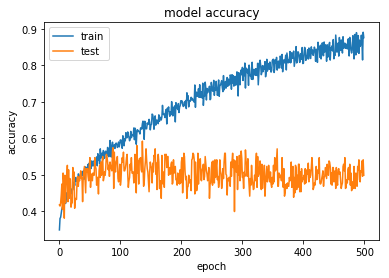

In [760]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

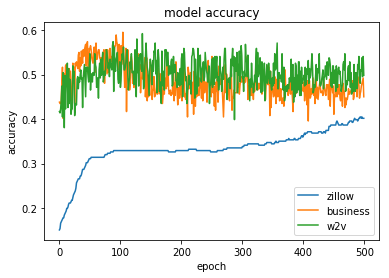

In [761]:
plt.plot(zillow_model.history['val_acc'])
plt.plot(business_model.history['val_acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['zillow', 'business', 'w2v'], loc='lower right')
plt.show()

In [762]:
class_weight = {0 : 2,
    1: 1,
    2: .5,
    3: 1,
    4: 2}

In [763]:
X_test_cat_mod_df_2.head()

,0,1,2,3,4,loss,gain,1,2,3,4,5,gain_true_true,gain_stay,loss_true_true,loss_stay,gain_large,loss_large,gain_large_true,loss_large_true
0,4.386394e-03,1.050091e-01,1.591386e-01,0.356899,3.745667e-01,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,2.575360e-10,2.015372e-06,9.907100e-01,0.009283,5.487662e-06,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
2,1.422529e-10,2.247291e-07,9.999537e-01,0.000046,4.702748e-07,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
3,2.420212e-11,1.134737e-06,1.622263e-06,0.083518,9.164789e-01,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
4,5.406993e-33,1.000000e+00,7.781700e-19,0.000000,0.000000e+00,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [764]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [765]:
zillow_model_2 = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 4s 1ms/step - loss: 1.5175 - acc: 0.1955 - val_loss: 1.6007 - val_acc: 0.3323
Epoch 2/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.5223 - acc: 0.1944 - val_loss: 1.6000 - val_acc: 0.3353
Epoch 3/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.5247 - acc: 0.1948 - val_loss: 1.5993 - val_acc: 0.3353
Epoch 4/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.5229 - acc: 0.1874 - val_loss: 1.5987 - val_acc: 0.3353
Epoch 5/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5271 - acc: 0.1948 - val_loss: 1.5982 - val_acc: 0.3353
Epoch 6/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.5183 - acc: 0.2018 - val_loss: 1.5978 - val_acc: 0.3384
Epoch 7/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5186 - acc: 0.2015 - val_loss: 1.5974 - val_acc: 0.

2839/2839 [==============================] - 0s 27us/step - loss: 1.4955 - acc: 0.2071 - val_loss: 1.5778 - val_acc: 0.3384
Epoch 61/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4858 - acc: 0.2226 - val_loss: 1.5775 - val_acc: 0.3384
Epoch 62/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.4985 - acc: 0.2032 - val_loss: 1.5771 - val_acc: 0.3384
Epoch 63/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4947 - acc: 0.2089 - val_loss: 1.5768 - val_acc: 0.3384
Epoch 64/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4914 - acc: 0.2068 - val_loss: 1.5764 - val_acc: 0.3384
Epoch 65/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4945 - acc: 0.2138 - val_loss: 1.5761 - val_acc: 0.3384
Epoch 66/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.4926 - acc: 0.2223 - val_loss: 1.5757 - val_acc: 0.3384
Epoch 67/1000
2839/2839 [=======================

Epoch 120/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4659 - acc: 0.2353 - val_loss: 1.5567 - val_acc: 0.3202
Epoch 121/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4793 - acc: 0.2237 - val_loss: 1.5565 - val_acc: 0.3112
Epoch 122/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.4711 - acc: 0.2353 - val_loss: 1.5560 - val_acc: 0.3051
Epoch 123/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.4738 - acc: 0.2290 - val_loss: 1.5556 - val_acc: 0.3112
Epoch 124/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.4747 - acc: 0.2110 - val_loss: 1.5553 - val_acc: 0.3142
Epoch 125/1000
2839/2839 [==============================] - 0s 29us/step - loss: 1.4743 - acc: 0.2321 - val_loss: 1.5549 - val_acc: 0.3142
Epoch 126/1000
2839/2839 [==============================] - 0s 29us/step - loss: 1.4651 - acc: 0.2332 - val_loss: 1.5545 - val_acc: 0.3172
Epoch 127/1000
2839/2839 [=

Epoch 179/1000
2839/2839 [==============================] - 0s 34us/step - loss: 1.4508 - acc: 0.2466 - val_loss: 1.5359 - val_acc: 0.3595
Epoch 180/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.4465 - acc: 0.2526 - val_loss: 1.5356 - val_acc: 0.3505
Epoch 181/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4488 - acc: 0.2515 - val_loss: 1.5352 - val_acc: 0.3535
Epoch 182/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4495 - acc: 0.2575 - val_loss: 1.5350 - val_acc: 0.3535
Epoch 183/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.4577 - acc: 0.2466 - val_loss: 1.5346 - val_acc: 0.3505
Epoch 184/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4585 - acc: 0.2508 - val_loss: 1.5344 - val_acc: 0.3505
Epoch 185/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4532 - acc: 0.2603 - val_loss: 1.5341 - val_acc: 0.3505
Epoch 186/1000
2839/2839 [=

Epoch 238/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4421 - acc: 0.2614 - val_loss: 1.5162 - val_acc: 0.3384
Epoch 239/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4289 - acc: 0.2681 - val_loss: 1.5158 - val_acc: 0.3384
Epoch 240/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4311 - acc: 0.2589 - val_loss: 1.5155 - val_acc: 0.3384
Epoch 241/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.4355 - acc: 0.2695 - val_loss: 1.5153 - val_acc: 0.3384
Epoch 242/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4314 - acc: 0.2603 - val_loss: 1.5149 - val_acc: 0.3414
Epoch 243/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.4302 - acc: 0.2790 - val_loss: 1.5147 - val_acc: 0.3414
Epoch 244/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4356 - acc: 0.2621 - val_loss: 1.5144 - val_acc: 0.3414
Epoch 245/1000
2839/2839 [=

Epoch 297/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.4219 - acc: 0.2828 - val_loss: 1.4991 - val_acc: 0.3263
Epoch 298/1000
2839/2839 [==============================] - 0s 29us/step - loss: 1.4122 - acc: 0.3033 - val_loss: 1.4987 - val_acc: 0.3263
Epoch 299/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4051 - acc: 0.2807 - val_loss: 1.4983 - val_acc: 0.3263
Epoch 300/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.4069 - acc: 0.2934 - val_loss: 1.4980 - val_acc: 0.3263
Epoch 301/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4152 - acc: 0.2783 - val_loss: 1.4977 - val_acc: 0.3263
Epoch 302/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4100 - acc: 0.2931 - val_loss: 1.4975 - val_acc: 0.3263
Epoch 303/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.4202 - acc: 0.2811 - val_loss: 1.4972 - val_acc: 0.3263
Epoch 304/1000
2839/2839 [=

Epoch 356/1000
2839/2839 [==============================] - 0s 29us/step - loss: 1.3951 - acc: 0.2864 - val_loss: 1.4849 - val_acc: 0.3263
Epoch 357/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3963 - acc: 0.2874 - val_loss: 1.4846 - val_acc: 0.3263
Epoch 358/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.3926 - acc: 0.2888 - val_loss: 1.4844 - val_acc: 0.3263
Epoch 359/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.4026 - acc: 0.2821 - val_loss: 1.4843 - val_acc: 0.3263
Epoch 360/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.4066 - acc: 0.2850 - val_loss: 1.4841 - val_acc: 0.3263
Epoch 361/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3934 - acc: 0.2864 - val_loss: 1.4839 - val_acc: 0.3263
Epoch 362/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3996 - acc: 0.2924 - val_loss: 1.4838 - val_acc: 0.3263
Epoch 363/1000
2839/2839 [=

Epoch 415/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3840 - acc: 0.3033 - val_loss: 1.4751 - val_acc: 0.3293
Epoch 416/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3885 - acc: 0.3093 - val_loss: 1.4749 - val_acc: 0.3293
Epoch 417/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3773 - acc: 0.2983 - val_loss: 1.4748 - val_acc: 0.3293
Epoch 418/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.3846 - acc: 0.3057 - val_loss: 1.4746 - val_acc: 0.3293
Epoch 419/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3788 - acc: 0.2906 - val_loss: 1.4745 - val_acc: 0.3293
Epoch 420/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3806 - acc: 0.3047 - val_loss: 1.4743 - val_acc: 0.3293
Epoch 421/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3848 - acc: 0.2962 - val_loss: 1.4742 - val_acc: 0.3293
Epoch 422/1000
2839/2839 [=

Epoch 474/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3730 - acc: 0.3110 - val_loss: 1.4683 - val_acc: 0.3293
Epoch 475/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3704 - acc: 0.3100 - val_loss: 1.4681 - val_acc: 0.3293
Epoch 476/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3704 - acc: 0.3114 - val_loss: 1.4682 - val_acc: 0.3293
Epoch 477/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3718 - acc: 0.3138 - val_loss: 1.4680 - val_acc: 0.3293
Epoch 478/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3773 - acc: 0.3103 - val_loss: 1.4678 - val_acc: 0.3293
Epoch 479/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3746 - acc: 0.3103 - val_loss: 1.4678 - val_acc: 0.3293
Epoch 480/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3720 - acc: 0.3121 - val_loss: 1.4677 - val_acc: 0.3293
Epoch 481/1000
2839/2839 [=

Epoch 533/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3589 - acc: 0.3234 - val_loss: 1.4643 - val_acc: 0.3293
Epoch 534/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3555 - acc: 0.3272 - val_loss: 1.4642 - val_acc: 0.3293
Epoch 535/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3479 - acc: 0.3241 - val_loss: 1.4642 - val_acc: 0.3293
Epoch 536/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3637 - acc: 0.3170 - val_loss: 1.4642 - val_acc: 0.3293
Epoch 537/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3618 - acc: 0.3047 - val_loss: 1.4642 - val_acc: 0.3293
Epoch 538/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3574 - acc: 0.3170 - val_loss: 1.4642 - val_acc: 0.3293
Epoch 539/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3540 - acc: 0.3110 - val_loss: 1.4642 - val_acc: 0.3293
Epoch 540/1000
2839/2839 [=

Epoch 592/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3547 - acc: 0.3170 - val_loss: 1.4631 - val_acc: 0.3293
Epoch 593/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3507 - acc: 0.3332 - val_loss: 1.4632 - val_acc: 0.3293
Epoch 594/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3336 - acc: 0.3332 - val_loss: 1.4630 - val_acc: 0.3293
Epoch 595/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3614 - acc: 0.3156 - val_loss: 1.4630 - val_acc: 0.3293
Epoch 596/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3525 - acc: 0.3325 - val_loss: 1.4629 - val_acc: 0.3293
Epoch 597/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3446 - acc: 0.3128 - val_loss: 1.4629 - val_acc: 0.3293
Epoch 598/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3581 - acc: 0.3202 - val_loss: 1.4629 - val_acc: 0.3293
Epoch 599/1000
2839/2839 [=

Epoch 651/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3495 - acc: 0.3174 - val_loss: 1.4633 - val_acc: 0.3323
Epoch 652/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3475 - acc: 0.3269 - val_loss: 1.4634 - val_acc: 0.3323
Epoch 653/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3340 - acc: 0.3318 - val_loss: 1.4635 - val_acc: 0.3323
Epoch 654/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3405 - acc: 0.3262 - val_loss: 1.4636 - val_acc: 0.3323
Epoch 655/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3357 - acc: 0.3339 - val_loss: 1.4637 - val_acc: 0.3323
Epoch 656/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3427 - acc: 0.3308 - val_loss: 1.4637 - val_acc: 0.3323
Epoch 657/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3313 - acc: 0.3477 - val_loss: 1.4636 - val_acc: 0.3323
Epoch 658/1000
2839/2839 [=

Epoch 710/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3311 - acc: 0.3251 - val_loss: 1.4637 - val_acc: 0.3323
Epoch 711/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3441 - acc: 0.3212 - val_loss: 1.4637 - val_acc: 0.3323
Epoch 712/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3377 - acc: 0.3455 - val_loss: 1.4638 - val_acc: 0.3323
Epoch 713/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3330 - acc: 0.3279 - val_loss: 1.4639 - val_acc: 0.3323
Epoch 714/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3399 - acc: 0.3262 - val_loss: 1.4639 - val_acc: 0.3323
Epoch 715/1000
2839/2839 [==============================] - 0s 29us/step - loss: 1.3291 - acc: 0.3434 - val_loss: 1.4640 - val_acc: 0.3323
Epoch 716/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3414 - acc: 0.3297 - val_loss: 1.4641 - val_acc: 0.3323
Epoch 717/1000
2839/2839 [=

Epoch 769/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3257 - acc: 0.3339 - val_loss: 1.4654 - val_acc: 0.3293
Epoch 770/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3318 - acc: 0.3374 - val_loss: 1.4654 - val_acc: 0.3293
Epoch 771/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3298 - acc: 0.3329 - val_loss: 1.4654 - val_acc: 0.3293
Epoch 772/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3254 - acc: 0.3378 - val_loss: 1.4653 - val_acc: 0.3293
Epoch 773/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3292 - acc: 0.3371 - val_loss: 1.4652 - val_acc: 0.3293
Epoch 774/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3214 - acc: 0.3445 - val_loss: 1.4653 - val_acc: 0.3293
Epoch 775/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3152 - acc: 0.3417 - val_loss: 1.4654 - val_acc: 0.3293
Epoch 776/1000
2839/2839 [=

Epoch 828/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3208 - acc: 0.3378 - val_loss: 1.4670 - val_acc: 0.3293
Epoch 829/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3237 - acc: 0.3385 - val_loss: 1.4671 - val_acc: 0.3293
Epoch 830/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3129 - acc: 0.3480 - val_loss: 1.4670 - val_acc: 0.3293
Epoch 831/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3251 - acc: 0.3462 - val_loss: 1.4668 - val_acc: 0.3293
Epoch 832/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3114 - acc: 0.3357 - val_loss: 1.4671 - val_acc: 0.3293
Epoch 833/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3227 - acc: 0.3343 - val_loss: 1.4670 - val_acc: 0.3293
Epoch 834/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3101 - acc: 0.3487 - val_loss: 1.4672 - val_acc: 0.3293
Epoch 835/1000
2839/2839 [=

Epoch 887/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3203 - acc: 0.3357 - val_loss: 1.4681 - val_acc: 0.3293
Epoch 888/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3151 - acc: 0.3473 - val_loss: 1.4680 - val_acc: 0.3293
Epoch 889/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3119 - acc: 0.3505 - val_loss: 1.4680 - val_acc: 0.3293
Epoch 890/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3269 - acc: 0.3346 - val_loss: 1.4680 - val_acc: 0.3293
Epoch 891/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3285 - acc: 0.3371 - val_loss: 1.4680 - val_acc: 0.3293
Epoch 892/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3027 - acc: 0.3462 - val_loss: 1.4681 - val_acc: 0.3293
Epoch 893/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3141 - acc: 0.3491 - val_loss: 1.4682 - val_acc: 0.3293
Epoch 894/1000
2839/2839 [=

Epoch 946/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3142 - acc: 0.3392 - val_loss: 1.4694 - val_acc: 0.3293
Epoch 947/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3199 - acc: 0.3417 - val_loss: 1.4694 - val_acc: 0.3293
Epoch 948/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3173 - acc: 0.3470 - val_loss: 1.4694 - val_acc: 0.3293
Epoch 949/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.2991 - acc: 0.3533 - val_loss: 1.4695 - val_acc: 0.3293
Epoch 950/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3052 - acc: 0.3547 - val_loss: 1.4693 - val_acc: 0.3293
Epoch 951/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3143 - acc: 0.3455 - val_loss: 1.4694 - val_acc: 0.3293
Epoch 952/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3254 - acc: 0.3329 - val_loss: 1.4693 - val_acc: 0.3293
Epoch 953/1000
2839/2839 [=

In [767]:
predictions = model.predict(X_test)
model_metrics(predictions, y_cat_test)

ZeroDivisionError: division by zero

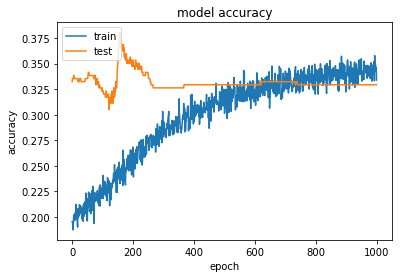

In [768]:
plt.plot(zillow_model_2.history['acc'])
plt.plot(zillow_model_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [769]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [770]:
business_model_2 = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 4s 2ms/step - loss: 1.6218 - acc: 0.2998 - val_loss: 1.5722 - val_acc: 0.3323
Epoch 2/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.4104 - acc: 0.3519 - val_loss: 1.6386 - val_acc: 0.3323
Epoch 3/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.4149 - acc: 0.3452 - val_loss: 1.5748 - val_acc: 0.3323
Epoch 4/1000
2839/2839 [==============================] - 0s 33us/step - loss: 1.3846 - acc: 0.3667 - val_loss: 1.5040 - val_acc: 0.3323
Epoch 5/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.3682 - acc: 0.3610 - val_loss: 1.5195 - val_acc: 0.3323
Epoch 6/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.3570 - acc: 0.3868 - val_loss: 1.4774 - val_acc: 0.3323
Epoch 7/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.3649 - acc: 0.3607 - val_loss: 1.4647 - val_acc: 0.

Epoch 60/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1253 - acc: 0.4597 - val_loss: 1.2731 - val_acc: 0.4773
Epoch 61/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1159 - acc: 0.4600 - val_loss: 1.2432 - val_acc: 0.4864
Epoch 62/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1137 - acc: 0.4794 - val_loss: 1.2280 - val_acc: 0.4924
Epoch 63/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1072 - acc: 0.4709 - val_loss: 1.2507 - val_acc: 0.4955
Epoch 64/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1117 - acc: 0.4678 - val_loss: 1.2970 - val_acc: 0.4562
Epoch 65/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1148 - acc: 0.4618 - val_loss: 1.2380 - val_acc: 0.5015
Epoch 66/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.0901 - acc: 0.4762 - val_loss: 1.2609 - val_acc: 0.4894
Epoch 67/1000
2839/2839 [=========

2839/2839 [==============================] - 0s 33us/step - loss: 0.9987 - acc: 0.4995 - val_loss: 1.1464 - val_acc: 0.5227
Epoch 120/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.9523 - acc: 0.5277 - val_loss: 1.1296 - val_acc: 0.5196
Epoch 121/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.9589 - acc: 0.5262 - val_loss: 1.1128 - val_acc: 0.5378
Epoch 122/1000
2839/2839 [==============================] - 0s 35us/step - loss: 0.9603 - acc: 0.5231 - val_loss: 1.1171 - val_acc: 0.5196
Epoch 123/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.9882 - acc: 0.5157 - val_loss: 1.1400 - val_acc: 0.4985
Epoch 124/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.9756 - acc: 0.5262 - val_loss: 1.1498 - val_acc: 0.5136
Epoch 125/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.9532 - acc: 0.5241 - val_loss: 1.1209 - val_acc: 0.5227
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.8324 - acc: 0.5745 - val_loss: 1.2077 - val_acc: 0.4864
Epoch 179/1000
2839/2839 [==============================] - 0s 35us/step - loss: 0.8546 - acc: 0.5555 - val_loss: 1.1684 - val_acc: 0.5106
Epoch 180/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.8400 - acc: 0.5601 - val_loss: 1.1801 - val_acc: 0.4924
Epoch 181/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8408 - acc: 0.5653 - val_loss: 1.1570 - val_acc: 0.5106
Epoch 182/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.8423 - acc: 0.5632 - val_loss: 1.1770 - val_acc: 0.4985
Epoch 183/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8320 - acc: 0.5611 - val_loss: 1.1892 - val_acc: 0.4924
Epoch 184/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.8336 - acc: 0.5646 - val_loss: 1.2114 - val_acc: 0.4804
Epoch 185/1000
2839/2839 [================

Epoch 237/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7892 - acc: 0.5794 - val_loss: 1.3249 - val_acc: 0.4592
Epoch 238/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7584 - acc: 0.5872 - val_loss: 1.4036 - val_acc: 0.4109
Epoch 239/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.7951 - acc: 0.5597 - val_loss: 1.3416 - val_acc: 0.4320
Epoch 240/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7542 - acc: 0.5886 - val_loss: 1.2986 - val_acc: 0.4683
Epoch 241/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7551 - acc: 0.6041 - val_loss: 1.2773 - val_acc: 0.4834
Epoch 242/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7533 - acc: 0.5868 - val_loss: 1.2759 - val_acc: 0.4834
Epoch 243/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7410 - acc: 0.5970 - val_loss: 1.2909 - val_acc: 0.4622
Epoch 244/1000
2839/2839 [=

2839/2839 [==============================] - 0s 38us/step - loss: 0.6540 - acc: 0.6414 - val_loss: 1.3995 - val_acc: 0.4773
Epoch 296/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6622 - acc: 0.6411 - val_loss: 1.4727 - val_acc: 0.4441
Epoch 297/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6973 - acc: 0.6132 - val_loss: 1.4935 - val_acc: 0.4139
Epoch 298/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.7155 - acc: 0.5974 - val_loss: 1.4446 - val_acc: 0.4683
Epoch 299/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.6679 - acc: 0.6375 - val_loss: 1.5201 - val_acc: 0.4169
Epoch 300/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7119 - acc: 0.6217 - val_loss: 1.4707 - val_acc: 0.4441
Epoch 301/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6800 - acc: 0.6291 - val_loss: 1.4617 - val_acc: 0.4622
Epoch 302/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.5756 - acc: 0.6809 - val_loss: 1.4422 - val_acc: 0.4894
Epoch 355/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5797 - acc: 0.6826 - val_loss: 1.4323 - val_acc: 0.5106
Epoch 356/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6147 - acc: 0.6615 - val_loss: 1.4141 - val_acc: 0.5076
Epoch 357/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6464 - acc: 0.6601 - val_loss: 1.4993 - val_acc: 0.4713
Epoch 358/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6891 - acc: 0.6365 - val_loss: 1.5588 - val_acc: 0.4441
Epoch 359/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6480 - acc: 0.6714 - val_loss: 1.5473 - val_acc: 0.4653
Epoch 360/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6023 - acc: 0.6696 - val_loss: 1.5231 - val_acc: 0.4592
Epoch 361/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.5611 - acc: 0.6707 - val_loss: 1.5924 - val_acc: 0.4834
Epoch 414/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5681 - acc: 0.6763 - val_loss: 1.6197 - val_acc: 0.4562
Epoch 415/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.5714 - acc: 0.6721 - val_loss: 1.5604 - val_acc: 0.4622
Epoch 416/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5397 - acc: 0.6932 - val_loss: 1.5701 - val_acc: 0.4864
Epoch 417/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5337 - acc: 0.6900 - val_loss: 1.6070 - val_acc: 0.4683
Epoch 418/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5387 - acc: 0.6918 - val_loss: 1.7844 - val_acc: 0.4471
Epoch 419/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5905 - acc: 0.6696 - val_loss: 1.9311 - val_acc: 0.3807
Epoch 420/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.5093 - acc: 0.7143 - val_loss: 1.5461 - val_acc: 0.5196
Epoch 473/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5525 - acc: 0.6883 - val_loss: 1.5191 - val_acc: 0.5166
Epoch 474/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5150 - acc: 0.7098 - val_loss: 1.5683 - val_acc: 0.4985
Epoch 475/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5170 - acc: 0.7179 - val_loss: 1.6034 - val_acc: 0.4924
Epoch 476/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5197 - acc: 0.7231 - val_loss: 1.5960 - val_acc: 0.4985
Epoch 477/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5092 - acc: 0.7235 - val_loss: 1.6252 - val_acc: 0.4864
Epoch 478/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.4869 - acc: 0.7344 - val_loss: 1.5920 - val_acc: 0.4955
Epoch 479/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.4833 - acc: 0.7182 - val_loss: 1.9485 - val_acc: 0.4139
Epoch 532/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5998 - acc: 0.6559 - val_loss: 1.8272 - val_acc: 0.4411
Epoch 533/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4903 - acc: 0.7129 - val_loss: 1.7700 - val_acc: 0.4683
Epoch 534/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4395 - acc: 0.7478 - val_loss: 1.7491 - val_acc: 0.4864
Epoch 535/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4405 - acc: 0.7510 - val_loss: 1.7926 - val_acc: 0.4502
Epoch 536/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4589 - acc: 0.7291 - val_loss: 1.9791 - val_acc: 0.4230
Epoch 537/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5022 - acc: 0.7175 - val_loss: 1.8158 - val_acc: 0.4562
Epoch 538/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.4317 - acc: 0.7457 - val_loss: 1.7721 - val_acc: 0.5408
Epoch 591/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4393 - acc: 0.7527 - val_loss: 1.8185 - val_acc: 0.5015
Epoch 592/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4480 - acc: 0.7408 - val_loss: 1.8415 - val_acc: 0.4713
Epoch 593/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4276 - acc: 0.7450 - val_loss: 1.8960 - val_acc: 0.4562
Epoch 594/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4498 - acc: 0.7369 - val_loss: 2.1037 - val_acc: 0.4109
Epoch 595/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5453 - acc: 0.7034 - val_loss: 1.9379 - val_acc: 0.4320
Epoch 596/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4273 - acc: 0.7439 - val_loss: 1.8596 - val_acc: 0.4653
Epoch 597/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.3764 - acc: 0.7865 - val_loss: 2.0198 - val_acc: 0.4864
Epoch 650/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4135 - acc: 0.7721 - val_loss: 2.0355 - val_acc: 0.4622
Epoch 651/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4555 - acc: 0.7411 - val_loss: 1.9568 - val_acc: 0.4773
Epoch 652/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4180 - acc: 0.7570 - val_loss: 1.9449 - val_acc: 0.4834
Epoch 653/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3770 - acc: 0.7784 - val_loss: 1.8947 - val_acc: 0.5015
Epoch 654/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4030 - acc: 0.7622 - val_loss: 1.8772 - val_acc: 0.5136
Epoch 655/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4080 - acc: 0.7619 - val_loss: 1.9304 - val_acc: 0.4804
Epoch 656/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.4593 - acc: 0.7675 - val_loss: 2.0254 - val_acc: 0.4743
Epoch 709/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4742 - acc: 0.7672 - val_loss: 1.9186 - val_acc: 0.4834
Epoch 710/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4174 - acc: 0.7806 - val_loss: 1.9461 - val_acc: 0.4743
Epoch 711/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3342 - acc: 0.8052 - val_loss: 2.0130 - val_acc: 0.4804
Epoch 712/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3297 - acc: 0.8144 - val_loss: 2.0166 - val_acc: 0.4894
Epoch 713/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3269 - acc: 0.8101 - val_loss: 2.0778 - val_acc: 0.4562
Epoch 714/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3267 - acc: 0.8091 - val_loss: 2.0878 - val_acc: 0.4743
Epoch 715/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.3093 - acc: 0.8249 - val_loss: 2.1904 - val_acc: 0.4653
Epoch 768/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3075 - acc: 0.8207 - val_loss: 2.2085 - val_acc: 0.4924
Epoch 769/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3127 - acc: 0.8221 - val_loss: 2.3771 - val_acc: 0.4502
Epoch 770/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3518 - acc: 0.7999 - val_loss: 2.3950 - val_acc: 0.4411
Epoch 771/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3851 - acc: 0.7915 - val_loss: 2.2933 - val_acc: 0.4683
Epoch 772/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3323 - acc: 0.8168 - val_loss: 2.2767 - val_acc: 0.4653
Epoch 773/1000
2839/2839 [==============================] - 0s 37us/step - loss: 0.3017 - acc: 0.8323 - val_loss: 2.2727 - val_acc: 0.4502
Epoch 774/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.3097 - acc: 0.8369 - val_loss: 2.2644 - val_acc: 0.4955
Epoch 827/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3268 - acc: 0.8344 - val_loss: 2.3361 - val_acc: 0.4713
Epoch 828/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2924 - acc: 0.8355 - val_loss: 2.3124 - val_acc: 0.4955
Epoch 829/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.2998 - acc: 0.8295 - val_loss: 2.3831 - val_acc: 0.4683
Epoch 830/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.3455 - acc: 0.8161 - val_loss: 2.4718 - val_acc: 0.4502
Epoch 831/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3879 - acc: 0.7943 - val_loss: 2.4282 - val_acc: 0.4411
Epoch 832/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3509 - acc: 0.8024 - val_loss: 2.2824 - val_acc: 0.4834
Epoch 833/1000
2839/2839 [================

2839/2839 [==============================] - 0s 33us/step - loss: 0.3745 - acc: 0.8207 - val_loss: 2.3377 - val_acc: 0.4985
Epoch 886/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3128 - acc: 0.8320 - val_loss: 2.3241 - val_acc: 0.4894
Epoch 887/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3421 - acc: 0.8253 - val_loss: 2.3239 - val_acc: 0.5045
Epoch 888/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3146 - acc: 0.8309 - val_loss: 2.3437 - val_acc: 0.5106
Epoch 889/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3210 - acc: 0.8320 - val_loss: 2.3449 - val_acc: 0.5045
Epoch 890/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2601 - acc: 0.8524 - val_loss: 2.4241 - val_acc: 0.5136
Epoch 891/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2690 - acc: 0.8482 - val_loss: 2.5053 - val_acc: 0.5015
Epoch 892/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.2662 - acc: 0.8510 - val_loss: 2.6738 - val_acc: 0.4743
Epoch 945/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.2673 - acc: 0.8514 - val_loss: 2.6615 - val_acc: 0.4683
Epoch 946/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2650 - acc: 0.8559 - val_loss: 2.8272 - val_acc: 0.4502
Epoch 947/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3603 - acc: 0.8087 - val_loss: 2.7838 - val_acc: 0.4320
Epoch 948/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3383 - acc: 0.8175 - val_loss: 2.5438 - val_acc: 0.4924
Epoch 949/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.2788 - acc: 0.8489 - val_loss: 2.5466 - val_acc: 0.4743
Epoch 950/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2646 - acc: 0.8591 - val_loss: 2.4638 - val_acc: 0.4773
Epoch 951/1000
2839/2839 [================

In [771]:
predictions = model.predict(X_test_business)
model_metrics(predictions, y_cat_test_business)

67
0.7313432835820896
0.9402985074626866
26
0.7692307692307693
0.9615384615384616


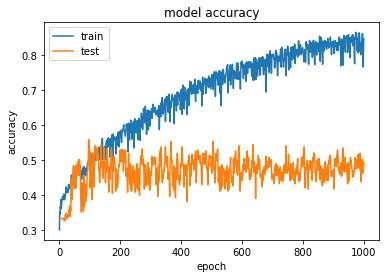

In [772]:
plt.plot(business_model_2.history['acc'])
plt.plot(business_model_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [773]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [774]:
w2v_model_2 = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 4s 2ms/step - loss: 1.9334 - acc: 0.1599 - val_loss: 1.5912 - val_acc: 0.0695
Epoch 2/1000
2839/2839 [==============================] - 0s 59us/step - loss: 1.4178 - acc: 0.2434 - val_loss: 1.5054 - val_acc: 0.3082
Epoch 3/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.3628 - acc: 0.3057 - val_loss: 1.4886 - val_acc: 0.3263
Epoch 4/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.3520 - acc: 0.3145 - val_loss: 1.4878 - val_acc: 0.3051
Epoch 5/1000
2839/2839 [==============================] - 0s 75us/step - loss: 1.3197 - acc: 0.3396 - val_loss: 1.4820 - val_acc: 0.3021
Epoch 6/1000
2839/2839 [==============================] - 0s 76us/step - loss: 1.3304 - acc: 0.3279 - val_loss: 1.4832 - val_acc: 0.3293
Epoch 7/1000
2839/2839 [==============================] - 0s 62us/step - loss: 1.3283 - acc: 0.3258 - val_loss: 1.4875 - val_acc: 0.

2839/2839 [==============================] - 0s 60us/step - loss: 1.1470 - acc: 0.4111 - val_loss: 1.3128 - val_acc: 0.3112
Epoch 61/1000
2839/2839 [==============================] - 0s 61us/step - loss: 1.0802 - acc: 0.4251 - val_loss: 1.3074 - val_acc: 0.3051
Epoch 62/1000
2839/2839 [==============================] - 0s 62us/step - loss: 1.0650 - acc: 0.4170 - val_loss: 1.3458 - val_acc: 0.3233
Epoch 63/1000
2839/2839 [==============================] - 0s 74us/step - loss: 1.1162 - acc: 0.4068 - val_loss: 1.3006 - val_acc: 0.3172
Epoch 64/1000
2839/2839 [==============================] - 0s 60us/step - loss: 1.0862 - acc: 0.4343 - val_loss: 1.2513 - val_acc: 0.3353
Epoch 65/1000
2839/2839 [==============================] - 0s 62us/step - loss: 1.1017 - acc: 0.4058 - val_loss: 1.2398 - val_acc: 0.3474
Epoch 66/1000
2839/2839 [==============================] - 0s 60us/step - loss: 1.1302 - acc: 0.4399 - val_loss: 1.3537 - val_acc: 0.2961
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 66us/step - loss: 1.0419 - acc: 0.4780 - val_loss: 1.2323 - val_acc: 0.3988
Epoch 120/1000
2839/2839 [==============================] - 0s 77us/step - loss: 1.0080 - acc: 0.4822 - val_loss: 1.3174 - val_acc: 0.3746
Epoch 121/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.9680 - acc: 0.4642 - val_loss: 1.3483 - val_acc: 0.3625
Epoch 122/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.9519 - acc: 0.4699 - val_loss: 1.3738 - val_acc: 0.3535
Epoch 123/1000
2839/2839 [==============================] - 0s 91us/step - loss: 0.9759 - acc: 0.4537 - val_loss: 1.3980 - val_acc: 0.3414
Epoch 124/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.9705 - acc: 0.4699 - val_loss: 1.4251 - val_acc: 0.3474
Epoch 125/1000
2839/2839 [==============================] - 0s 78us/step - loss: 1.0154 - acc: 0.4621 - val_loss: 1.2888 - val_acc: 0.3444
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 65us/step - loss: 0.8500 - acc: 0.5195 - val_loss: 1.1832 - val_acc: 0.4653
Epoch 179/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.8892 - acc: 0.5090 - val_loss: 1.1691 - val_acc: 0.4502
Epoch 180/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.9608 - acc: 0.5248 - val_loss: 1.2741 - val_acc: 0.4109
Epoch 181/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.8794 - acc: 0.5234 - val_loss: 1.2825 - val_acc: 0.4350
Epoch 182/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.9287 - acc: 0.5048 - val_loss: 1.2268 - val_acc: 0.4381
Epoch 183/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.8896 - acc: 0.5294 - val_loss: 1.1960 - val_acc: 0.4532
Epoch 184/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9262 - acc: 0.5284 - val_loss: 1.1836 - val_acc: 0.4653
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 63us/step - loss: 0.8204 - acc: 0.5231 - val_loss: 1.3535 - val_acc: 0.4169
Epoch 238/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.8665 - acc: 0.5224 - val_loss: 1.4098 - val_acc: 0.3716
Epoch 239/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.8545 - acc: 0.4970 - val_loss: 1.3783 - val_acc: 0.4048
Epoch 240/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7913 - acc: 0.5312 - val_loss: 1.3778 - val_acc: 0.4109
Epoch 241/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.7681 - acc: 0.5583 - val_loss: 1.4609 - val_acc: 0.3867
Epoch 242/1000
2839/2839 [==============================] - ETA: 0s - loss: 0.8408 - acc: 0.501 - 0s 70us/step - loss: 0.8387 - acc: 0.5262 - val_loss: 1.3860 - val_acc: 0.4048
Epoch 243/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7936 - acc: 0.5548 - val_loss: 1.4246 - val_acc: 0.3897
Epoc

Epoch 296/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.7347 - acc: 0.5882 - val_loss: 1.3465 - val_acc: 0.4502
Epoch 297/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.6843 - acc: 0.6002 - val_loss: 1.3338 - val_acc: 0.4532
Epoch 298/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.7757 - acc: 0.5724 - val_loss: 1.3233 - val_acc: 0.4199
Epoch 299/1000
2839/2839 [==============================] - 0s 60us/step - loss: 0.7980 - acc: 0.5579 - val_loss: 1.3769 - val_acc: 0.4532
Epoch 300/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.7423 - acc: 0.5808 - val_loss: 1.5390 - val_acc: 0.3746
Epoch 301/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.8119 - acc: 0.5368 - val_loss: 1.4805 - val_acc: 0.3897
Epoch 302/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.7223 - acc: 0.5692 - val_loss: 1.4438 - val_acc: 0.4290
Epoch 303/1000
2839/2839 [=

2839/2839 [==============================] - 0s 65us/step - loss: 0.6291 - acc: 0.6456 - val_loss: 1.5369 - val_acc: 0.4350
Epoch 355/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.6690 - acc: 0.6242 - val_loss: 1.5783 - val_acc: 0.4199
Epoch 356/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.7165 - acc: 0.6143 - val_loss: 1.6055 - val_acc: 0.4109
Epoch 357/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.6996 - acc: 0.6020 - val_loss: 1.5202 - val_acc: 0.4532
Epoch 358/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6339 - acc: 0.6245 - val_loss: 1.6372 - val_acc: 0.4230
Epoch 359/1000
2839/2839 [==============================] - 0s 90us/step - loss: 0.7353 - acc: 0.5900 - val_loss: 1.6883 - val_acc: 0.3988
Epoch 360/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.7392 - acc: 0.5692 - val_loss: 1.5172 - val_acc: 0.4381
Epoch 361/1000
2839/2839 [================

2839/2839 [==============================] - 0s 76us/step - loss: 0.6594 - acc: 0.6189 - val_loss: 1.5286 - val_acc: 0.4199
Epoch 414/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.5831 - acc: 0.6383 - val_loss: 1.5755 - val_acc: 0.4381
Epoch 415/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5490 - acc: 0.6728 - val_loss: 1.5713 - val_acc: 0.4592
Epoch 416/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5773 - acc: 0.6481 - val_loss: 1.5423 - val_acc: 0.4653
Epoch 417/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.6063 - acc: 0.6456 - val_loss: 1.4981 - val_acc: 0.4924
Epoch 418/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.7344 - acc: 0.6044 - val_loss: 1.6302 - val_acc: 0.4441
Epoch 419/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.6689 - acc: 0.6400 - val_loss: 1.5776 - val_acc: 0.4592
Epoch 420/1000
2839/2839 [================

2839/2839 [==============================] - 0s 76us/step - loss: 0.5883 - acc: 0.6657 - val_loss: 1.8566 - val_acc: 0.3625
Epoch 473/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.7366 - acc: 0.5706 - val_loss: 1.7075 - val_acc: 0.4260
Epoch 474/1000
2839/2839 [==============================] - 0s 81us/step - loss: 0.5711 - acc: 0.6513 - val_loss: 1.6487 - val_acc: 0.4532
Epoch 475/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5239 - acc: 0.6925 - val_loss: 1.6370 - val_acc: 0.4381
Epoch 476/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5498 - acc: 0.6661 - val_loss: 1.6016 - val_acc: 0.4834
Epoch 477/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.5960 - acc: 0.6552 - val_loss: 1.5790 - val_acc: 0.4502
Epoch 478/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5351 - acc: 0.6566 - val_loss: 1.6604 - val_acc: 0.4532
Epoch 479/1000
2839/2839 [================

2839/2839 [==============================] - 0s 69us/step - loss: 0.4688 - acc: 0.7281 - val_loss: 1.8828 - val_acc: 0.4350
Epoch 532/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5263 - acc: 0.7031 - val_loss: 1.7442 - val_acc: 0.4683
Epoch 533/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7155 - acc: 0.6471 - val_loss: 1.6730 - val_acc: 0.4713
Epoch 534/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.5522 - acc: 0.6964 - val_loss: 1.7427 - val_acc: 0.4562
Epoch 535/1000
2839/2839 [==============================] - 0s 86us/step - loss: 0.4663 - acc: 0.7246 - val_loss: 1.8025 - val_acc: 0.4411
Epoch 536/1000
2839/2839 [==============================] - 0s 82us/step - loss: 0.4635 - acc: 0.7298 - val_loss: 1.7692 - val_acc: 0.4381
Epoch 537/1000
2839/2839 [==============================] - 0s 79us/step - loss: 0.5138 - acc: 0.7041 - val_loss: 1.7538 - val_acc: 0.4320
Epoch 538/1000
2839/2839 [================

2839/2839 [==============================] - 0s 64us/step - loss: 0.6344 - acc: 0.6774 - val_loss: 1.9581 - val_acc: 0.4260
Epoch 591/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.5053 - acc: 0.7147 - val_loss: 1.9682 - val_acc: 0.4592
Epoch 592/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.4343 - acc: 0.7369 - val_loss: 2.2244 - val_acc: 0.4079
Epoch 593/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.5065 - acc: 0.7157 - val_loss: 2.2412 - val_acc: 0.4109
Epoch 594/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.5432 - acc: 0.6974 - val_loss: 2.0043 - val_acc: 0.4502
Epoch 595/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.4643 - acc: 0.7425 - val_loss: 1.9685 - val_acc: 0.4532
Epoch 596/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.4334 - acc: 0.7415 - val_loss: 2.0056 - val_acc: 0.4502
Epoch 597/1000
2839/2839 [================

2839/2839 [==============================] - 0s 65us/step - loss: 0.4100 - acc: 0.7386 - val_loss: 1.9785 - val_acc: 0.4532
Epoch 650/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3984 - acc: 0.7482 - val_loss: 2.1394 - val_acc: 0.4622
Epoch 651/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.3880 - acc: 0.7675 - val_loss: 2.0597 - val_acc: 0.4834
Epoch 652/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4060 - acc: 0.7598 - val_loss: 2.0590 - val_acc: 0.4562
Epoch 653/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4534 - acc: 0.7379 - val_loss: 1.9507 - val_acc: 0.4562
Epoch 654/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.5747 - acc: 0.6759 - val_loss: 1.8933 - val_acc: 0.4804
Epoch 655/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.4854 - acc: 0.7358 - val_loss: 2.0764 - val_acc: 0.4502
Epoch 656/1000
2839/2839 [================

2839/2839 [==============================] - 0s 72us/step - loss: 0.3761 - acc: 0.7735 - val_loss: 2.0560 - val_acc: 0.4653
Epoch 709/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.4108 - acc: 0.7460 - val_loss: 1.9853 - val_acc: 0.4653
Epoch 710/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4477 - acc: 0.7133 - val_loss: 1.9828 - val_acc: 0.4804
Epoch 711/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3934 - acc: 0.7563 - val_loss: 2.1479 - val_acc: 0.4713
Epoch 712/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.3978 - acc: 0.7647 - val_loss: 2.3416 - val_acc: 0.4713
Epoch 713/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5763 - acc: 0.7105 - val_loss: 2.3783 - val_acc: 0.4713
Epoch 714/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5300 - acc: 0.7397 - val_loss: 2.2353 - val_acc: 0.4320
Epoch 715/1000
2839/2839 [================

2839/2839 [==============================] - 0s 82us/step - loss: 0.3892 - acc: 0.7548 - val_loss: 2.3235 - val_acc: 0.4350
Epoch 768/1000
2839/2839 [==============================] - 0s 84us/step - loss: 0.3825 - acc: 0.7844 - val_loss: 2.2461 - val_acc: 0.4441
Epoch 769/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3377 - acc: 0.7943 - val_loss: 2.3133 - val_acc: 0.4350
Epoch 770/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3616 - acc: 0.7658 - val_loss: 2.2394 - val_acc: 0.4290
Epoch 771/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3920 - acc: 0.7619 - val_loss: 2.1800 - val_acc: 0.4230
Epoch 772/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4018 - acc: 0.7397 - val_loss: 2.1271 - val_acc: 0.4411
Epoch 773/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4149 - acc: 0.7369 - val_loss: 2.0451 - val_acc: 0.4562
Epoch 774/1000
2839/2839 [================

2839/2839 [==============================] - 0s 83us/step - loss: 0.3839 - acc: 0.7915 - val_loss: 2.3754 - val_acc: 0.4350
Epoch 827/1000
2839/2839 [==============================] - 0s 88us/step - loss: 0.3377 - acc: 0.8091 - val_loss: 2.3481 - val_acc: 0.4502
Epoch 828/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.3388 - acc: 0.7964 - val_loss: 2.3040 - val_acc: 0.4441
Epoch 829/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3426 - acc: 0.7830 - val_loss: 2.3839 - val_acc: 0.4804
Epoch 830/1000
2839/2839 [==============================] - 0s 92us/step - loss: 0.4184 - acc: 0.7689 - val_loss: 2.4053 - val_acc: 0.4441
Epoch 831/1000
2839/2839 [==============================] - 0s 88us/step - loss: 0.4054 - acc: 0.7622 - val_loss: 2.3853 - val_acc: 0.4532
Epoch 832/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.3336 - acc: 0.7904 - val_loss: 2.4659 - val_acc: 0.4532
Epoch 833/1000
2839/2839 [================

2839/2839 [==============================] - 0s 61us/step - loss: 0.3335 - acc: 0.8013 - val_loss: 2.4462 - val_acc: 0.5015
Epoch 886/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3182 - acc: 0.8123 - val_loss: 2.5856 - val_acc: 0.4773
Epoch 887/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3068 - acc: 0.8228 - val_loss: 2.6455 - val_acc: 0.4683
Epoch 888/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3060 - acc: 0.8267 - val_loss: 2.6398 - val_acc: 0.4773
Epoch 889/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3077 - acc: 0.8207 - val_loss: 2.6563 - val_acc: 0.4441
Epoch 890/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3648 - acc: 0.8056 - val_loss: 2.6201 - val_acc: 0.5317
Epoch 891/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.8935 - acc: 0.7105 - val_loss: 2.2136 - val_acc: 0.4260
Epoch 892/1000
2839/2839 [================

2839/2839 [==============================] - 0s 65us/step - loss: 0.2586 - acc: 0.8549 - val_loss: 2.9720 - val_acc: 0.4139
Epoch 945/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.3232 - acc: 0.8193 - val_loss: 3.0149 - val_acc: 0.4230
Epoch 946/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.4098 - acc: 0.7760 - val_loss: 2.7273 - val_acc: 0.4139
Epoch 947/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.3242 - acc: 0.8137 - val_loss: 2.6620 - val_acc: 0.4773
Epoch 948/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.2654 - acc: 0.8552 - val_loss: 2.6932 - val_acc: 0.4804
Epoch 949/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.2837 - acc: 0.8404 - val_loss: 2.6719 - val_acc: 0.4562
Epoch 950/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.2471 - acc: 0.8580 - val_loss: 2.9267 - val_acc: 0.4260
Epoch 951/1000
2839/2839 [================

In [775]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, y_cat_test_w2v)

54
0.7962962962962963
0.9629629629629629
22
0.7272727272727273
0.9545454545454546


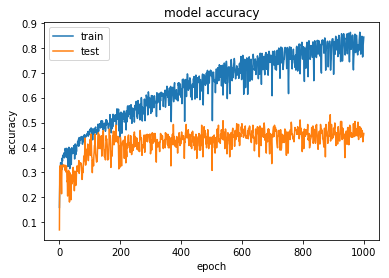

In [776]:
plt.plot(w2v_model_2.history['acc'])
plt.plot(w2v_model_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

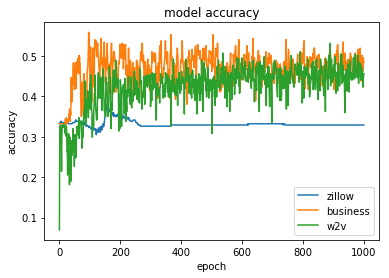

In [777]:
plt.plot(zillow_model_2.history['val_acc'])
plt.plot(business_model_2.history['val_acc'])
plt.plot(w2v_model_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['zillow', 'business', 'w2v'], loc='lower right')
plt.show()

In [394]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.4))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [395]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 2s 862us/step - loss: 1.1259 - acc: 0.1254 - val_loss: 1.9368 - val_acc: 0.1601
Epoch 2/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.1175 - acc: 0.1909 - val_loss: 1.9460 - val_acc: 0.1601
Epoch 3/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0942 - acc: 0.1997 - val_loss: 1.8857 - val_acc: 0.1601
Epoch 4/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0813 - acc: 0.2149 - val_loss: 1.7835 - val_acc: 0.1601
Epoch 5/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.0766 - acc: 0.2233 - val_loss: 1.7950 - val_acc: 0.1601
Epoch 6/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0503 - acc: 0.2261 - val_loss: 1.7223 - val_acc: 0.1601
Epoch 7/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0509 - acc: 0.2279 - val_loss: 1.6586 - val_acc: 

2839/2839 [==============================] - 0s 74us/step - loss: 0.9216 - acc: 0.2990 - val_loss: 1.4096 - val_acc: 0.3112
Epoch 61/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.9407 - acc: 0.2839 - val_loss: 1.4566 - val_acc: 0.1873
Epoch 62/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.9277 - acc: 0.2747 - val_loss: 1.4364 - val_acc: 0.2931
Epoch 63/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.9177 - acc: 0.3054 - val_loss: 1.4107 - val_acc: 0.3082
Epoch 64/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.9259 - acc: 0.2959 - val_loss: 1.4824 - val_acc: 0.3595
Epoch 65/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.9149 - acc: 0.2934 - val_loss: 1.5134 - val_acc: 0.2115
Epoch 66/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.9199 - acc: 0.2920 - val_loss: 1.6228 - val_acc: 0.2296
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 65us/step - loss: 0.8636 - acc: 0.3149 - val_loss: 1.4710 - val_acc: 0.3293
Epoch 120/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.8552 - acc: 0.3420 - val_loss: 1.4579 - val_acc: 0.3414
Epoch 121/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.9083 - acc: 0.3308 - val_loss: 1.4489 - val_acc: 0.2840
Epoch 122/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.8591 - acc: 0.3061 - val_loss: 1.4250 - val_acc: 0.3776
Epoch 123/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.8610 - acc: 0.3212 - val_loss: 1.4169 - val_acc: 0.3897
Epoch 124/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.8369 - acc: 0.3515 - val_loss: 1.4557 - val_acc: 0.3414
Epoch 125/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.8428 - acc: 0.3470 - val_loss: 1.4852 - val_acc: 0.3112
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 84us/step - loss: 0.7772 - acc: 0.3540 - val_loss: 1.6051 - val_acc: 0.2508
Epoch 179/1000
2839/2839 [==============================] - 0s 82us/step - loss: 0.8090 - acc: 0.3262 - val_loss: 1.6834 - val_acc: 0.2296
Epoch 180/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.8153 - acc: 0.3293 - val_loss: 1.6268 - val_acc: 0.2447
Epoch 181/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.7980 - acc: 0.3272 - val_loss: 1.5503 - val_acc: 0.2900
Epoch 182/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.7672 - acc: 0.3709 - val_loss: 1.6704 - val_acc: 0.2266
Epoch 183/1000
2839/2839 [==============================] - 0s 87us/step - loss: 0.8060 - acc: 0.3184 - val_loss: 1.5536 - val_acc: 0.2900
Epoch 184/1000
2839/2839 [==============================] - 0s 84us/step - loss: 0.7750 - acc: 0.3617 - val_loss: 1.5546 - val_acc: 0.2870
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 73us/step - loss: 0.7154 - acc: 0.3783 - val_loss: 1.5555 - val_acc: 0.3233
Epoch 238/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.7267 - acc: 0.3617 - val_loss: 1.4729 - val_acc: 0.3746
Epoch 239/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.6975 - acc: 0.4019 - val_loss: 1.5899 - val_acc: 0.3535
Epoch 240/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.7246 - acc: 0.3762 - val_loss: 1.5678 - val_acc: 0.2779
Epoch 241/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.7328 - acc: 0.3649 - val_loss: 1.4721 - val_acc: 0.4048
Epoch 242/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.7362 - acc: 0.3963 - val_loss: 1.4760 - val_acc: 0.3807
Epoch 243/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.7168 - acc: 0.3917 - val_loss: 1.3785 - val_acc: 0.4381
Epoch 244/1000
2839/2839 [================

2839/2839 [==============================] - 0s 74us/step - loss: 0.7082 - acc: 0.3758 - val_loss: 1.5081 - val_acc: 0.3263
Epoch 297/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6711 - acc: 0.4047 - val_loss: 1.5195 - val_acc: 0.3263
Epoch 298/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.6412 - acc: 0.4086 - val_loss: 1.4381 - val_acc: 0.3323
Epoch 299/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.6233 - acc: 0.4093 - val_loss: 1.3705 - val_acc: 0.3927
Epoch 300/1000
2839/2839 [==============================] - 0s 81us/step - loss: 0.7093 - acc: 0.3843 - val_loss: 1.3830 - val_acc: 0.3897
Epoch 301/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.7069 - acc: 0.4026 - val_loss: 1.4870 - val_acc: 0.3263
Epoch 302/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.6542 - acc: 0.4065 - val_loss: 1.4787 - val_acc: 0.3535
Epoch 303/1000
2839/2839 [================

2839/2839 [==============================] - 0s 89us/step - loss: 0.6167 - acc: 0.4502 - val_loss: 1.4111 - val_acc: 0.3988
Epoch 356/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.5881 - acc: 0.4516 - val_loss: 1.3766 - val_acc: 0.4350
Epoch 357/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.6266 - acc: 0.4533 - val_loss: 1.4390 - val_acc: 0.3656
Epoch 358/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.6980 - acc: 0.3952 - val_loss: 1.5912 - val_acc: 0.3051
Epoch 359/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.6506 - acc: 0.4290 - val_loss: 1.6559 - val_acc: 0.2931
Epoch 360/1000
2839/2839 [==============================] - 0s 92us/step - loss: 0.6187 - acc: 0.4174 - val_loss: 1.4460 - val_acc: 0.4048
Epoch 361/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.5740 - acc: 0.4544 - val_loss: 1.4639 - val_acc: 0.3716
Epoch 362/1000
2839/2839 [================

2839/2839 [==============================] - 0s 66us/step - loss: 0.5072 - acc: 0.4819 - val_loss: 1.4998 - val_acc: 0.4230
Epoch 415/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5054 - acc: 0.4945 - val_loss: 1.5990 - val_acc: 0.4199
Epoch 416/1000
2839/2839 [==============================] - 0s 89us/step - loss: 0.6192 - acc: 0.4251 - val_loss: 1.6053 - val_acc: 0.4230
Epoch 417/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.6066 - acc: 0.4667 - val_loss: 1.5608 - val_acc: 0.3927
Epoch 418/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.5268 - acc: 0.4836 - val_loss: 1.5896 - val_acc: 0.4018
Epoch 419/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.5253 - acc: 0.4699 - val_loss: 1.5686 - val_acc: 0.4260
Epoch 420/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.5442 - acc: 0.4797 - val_loss: 1.6399 - val_acc: 0.3776
Epoch 421/1000
2839/2839 [================

2839/2839 [==============================] - 0s 71us/step - loss: 0.5310 - acc: 0.4857 - val_loss: 1.4770 - val_acc: 0.4441
Epoch 474/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.5340 - acc: 0.5012 - val_loss: 1.4997 - val_acc: 0.4743
Epoch 475/1000
2839/2839 [==============================] - 0s 81us/step - loss: 0.4835 - acc: 0.5143 - val_loss: 1.5272 - val_acc: 0.4562
Epoch 476/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.5523 - acc: 0.4917 - val_loss: 1.5044 - val_acc: 0.4471
Epoch 477/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5751 - acc: 0.4928 - val_loss: 1.7527 - val_acc: 0.3233
Epoch 478/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5992 - acc: 0.4350 - val_loss: 1.6747 - val_acc: 0.3776
Epoch 479/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6388 - acc: 0.4311 - val_loss: 1.5918 - val_acc: 0.3505
Epoch 480/1000
2839/2839 [================

2839/2839 [==============================] - 0s 63us/step - loss: 0.4860 - acc: 0.5122 - val_loss: 1.6600 - val_acc: 0.4320
Epoch 533/1000
2839/2839 [==============================] - 0s 79us/step - loss: 0.5195 - acc: 0.5019 - val_loss: 1.6670 - val_acc: 0.4169
Epoch 534/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5146 - acc: 0.5058 - val_loss: 1.6523 - val_acc: 0.4018
Epoch 535/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4668 - acc: 0.5129 - val_loss: 1.7986 - val_acc: 0.3444
Epoch 536/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4726 - acc: 0.5248 - val_loss: 1.8545 - val_acc: 0.3444
Epoch 537/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.5338 - acc: 0.4716 - val_loss: 1.8880 - val_acc: 0.2991
Epoch 538/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5556 - acc: 0.4565 - val_loss: 1.6702 - val_acc: 0.3776
Epoch 539/1000
2839/2839 [================

2839/2839 [==============================] - 0s 75us/step - loss: 0.4059 - acc: 0.5770 - val_loss: 1.7023 - val_acc: 0.4562
Epoch 591/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4163 - acc: 0.5643 - val_loss: 1.7251 - val_acc: 0.4502
Epoch 592/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.4179 - acc: 0.5653 - val_loss: 1.8518 - val_acc: 0.3958
Epoch 593/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.5036 - acc: 0.5005 - val_loss: 1.8656 - val_acc: 0.3807
Epoch 594/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6991 - acc: 0.4907 - val_loss: 2.1215 - val_acc: 0.2779
Epoch 595/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.6408 - acc: 0.3910 - val_loss: 1.9021 - val_acc: 0.3082
Epoch 596/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5103 - acc: 0.4533 - val_loss: 1.6093 - val_acc: 0.4320
Epoch 597/1000
2839/2839 [================

2839/2839 [==============================] - 0s 72us/step - loss: 0.4616 - acc: 0.5449 - val_loss: 1.6721 - val_acc: 0.4743
Epoch 650/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4145 - acc: 0.5724 - val_loss: 1.7559 - val_acc: 0.4230
Epoch 651/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3894 - acc: 0.5699 - val_loss: 1.8364 - val_acc: 0.4290
Epoch 652/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4335 - acc: 0.5601 - val_loss: 1.7663 - val_acc: 0.4834
Epoch 653/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.4942 - acc: 0.5347 - val_loss: 1.7296 - val_acc: 0.4441
Epoch 654/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.4673 - acc: 0.5516 - val_loss: 1.7794 - val_acc: 0.4169
Epoch 655/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4290 - acc: 0.5347 - val_loss: 1.8343 - val_acc: 0.3988
Epoch 656/1000
2839/2839 [================

Epoch 708/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4129 - acc: 0.5629 - val_loss: 1.8655 - val_acc: 0.4079
Epoch 709/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4165 - acc: 0.5664 - val_loss: 2.2811 - val_acc: 0.3505
Epoch 710/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5894 - acc: 0.4579 - val_loss: 1.7339 - val_acc: 0.4653
Epoch 711/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.4168 - acc: 0.5918 - val_loss: 1.8183 - val_acc: 0.4350
Epoch 712/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3647 - acc: 0.6164 - val_loss: 1.8989 - val_acc: 0.4230
Epoch 713/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3855 - acc: 0.5942 - val_loss: 1.8721 - val_acc: 0.4048
Epoch 714/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4007 - acc: 0.5579 - val_loss: 1.8019 - val_acc: 0.4471
Epoch 715/1000
2839/2839 [=

Epoch 767/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3497 - acc: 0.6386 - val_loss: 1.8948 - val_acc: 0.4653
Epoch 768/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3265 - acc: 0.6386 - val_loss: 1.8998 - val_acc: 0.4713
Epoch 769/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3666 - acc: 0.6221 - val_loss: 1.8874 - val_acc: 0.4955
Epoch 770/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3985 - acc: 0.6027 - val_loss: 1.9396 - val_acc: 0.4562
Epoch 771/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4203 - acc: 0.5837 - val_loss: 1.8781 - val_acc: 0.4622
Epoch 772/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3806 - acc: 0.6136 - val_loss: 1.8568 - val_acc: 0.4743
Epoch 773/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3852 - acc: 0.6182 - val_loss: 1.9979 - val_acc: 0.4653
Epoch 774/1000
2839/2839 [=

Epoch 826/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3957 - acc: 0.6210 - val_loss: 1.9429 - val_acc: 0.4713
Epoch 827/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3692 - acc: 0.6118 - val_loss: 1.8433 - val_acc: 0.4864
Epoch 828/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.4352 - acc: 0.6175 - val_loss: 2.0047 - val_acc: 0.4713
Epoch 829/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.4900 - acc: 0.5727 - val_loss: 1.8167 - val_acc: 0.4804
Epoch 830/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.3907 - acc: 0.6182 - val_loss: 1.9308 - val_acc: 0.4441
Epoch 831/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3343 - acc: 0.6439 - val_loss: 2.0983 - val_acc: 0.4350
Epoch 832/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3486 - acc: 0.6210 - val_loss: 2.0630 - val_acc: 0.4683
Epoch 833/1000
2839/2839 [=

Epoch 885/1000
2839/2839 [==============================] - 0s 82us/step - loss: 0.3266 - acc: 0.6671 - val_loss: 2.0353 - val_acc: 0.4773
Epoch 886/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3659 - acc: 0.6488 - val_loss: 2.1127 - val_acc: 0.4804
Epoch 887/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5176 - acc: 0.5224 - val_loss: 1.8774 - val_acc: 0.4864
Epoch 888/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4446 - acc: 0.6023 - val_loss: 1.9654 - val_acc: 0.4471
Epoch 889/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.3581 - acc: 0.6414 - val_loss: 1.9495 - val_acc: 0.4320
Epoch 890/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3335 - acc: 0.6404 - val_loss: 1.9375 - val_acc: 0.4743
Epoch 891/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3268 - acc: 0.6566 - val_loss: 2.1052 - val_acc: 0.4592
Epoch 892/1000
2839/2839 [=

2839/2839 [==============================] - 0s 67us/step - loss: 0.3690 - acc: 0.6213 - val_loss: 2.1446 - val_acc: 0.3867
Epoch 944/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3794 - acc: 0.6372 - val_loss: 2.1464 - val_acc: 0.4048
Epoch 945/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3464 - acc: 0.6171 - val_loss: 2.1270 - val_acc: 0.4532
Epoch 946/1000
2839/2839 [==============================] - 0s 79us/step - loss: 0.3354 - acc: 0.6414 - val_loss: 2.1109 - val_acc: 0.4471
Epoch 947/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3150 - acc: 0.6819 - val_loss: 2.1875 - val_acc: 0.4471
Epoch 948/1000
2839/2839 [==============================] - 0s 83us/step - loss: 0.3223 - acc: 0.6675 - val_loss: 2.1544 - val_acc: 0.4713
Epoch 949/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3669 - acc: 0.6111 - val_loss: 2.1154 - val_acc: 0.4532
Epoch 950/1000
2839/2839 [================

In [ ]:
#### Will add confusion matrix from below, play with more metrics, and further tune w2v model but end of effective
#### notebook

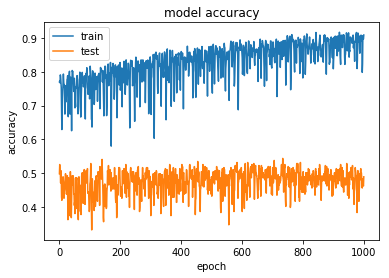

In [236]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [622]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, X_test, y_cat_test_w2v)

0.991869918699187


In [544]:
X_test_cat_mod = model.predict(X_test_w2v)

In [545]:
X_test_cat_mod_df = pd.DataFrame(X_test_cat_mod)

In [546]:
X_test_cat_mod_df['loss'] = np.where(X_test_cat_mod_df[0]> X_test_cat_mod_df[3], 1, 0)

In [547]:
X_test_cat_mod_df['gain'] = np.where(X_test_cat_mod_df[4]> X_test_cat_mod_df[1], 1, 0)

In [548]:
X_test_cat_mod_df_2 = pd.merge(X_test_cat_mod_df, y_cat_test_w2v, left_index=True, right_index=True, how='inner')

In [588]:
X_test_cat_mod_df_2['gain_large'] = np.where(X_test_cat_mod_df[4]> X_test_cat_mod_df[2], 1, 0)

In [597]:
X_test_cat_mod_df_2['loss_large'] = np.where(X_test_cat_mod_df[0]> X_test_cat_mod_df[2], 1, 0)

In [602]:
X_test_cat_mod_df_2['loss_large_true'] = np.where((X_test_cat_mod_df_2['loss_large'] == 1) & (X_test_cat_mod_df_2['2'] == 1) | (X_test_cat_mod_df_2['1'] == 1), 1, 0)

In [593]:
X_test_cat_mod_df_2['gain_large_true'] = np.where((X_test_cat_mod_df_2['gain_large'] == 1) & (X_test_cat_mod_df_2['4'] == 1) | (X_test_cat_mod_df_2['5'] == 1), 1, 0)

In [589]:
X_test_cat_mod_df_2['gain_true_true'] = np.where((X_test_cat_mod_df_2['gain'] == 1) & (X_test_cat_mod_df_2['4'] == 1) | (X_test_cat_mod_df_2['5'] == 1), 1, 0)

In [591]:
X_test_cat_mod_df_2['loss_large'] = np.where(X_test_cat_mod_df[0]> X_test_cat_mod_df[2], 1, 0)

In [566]:
X_test_cat_mod_df_2['gain_stay'] = np.where((X_test_cat_mod_df_2['gain'] == 1) & (X_test_cat_mod_df_2['3'] == 1), 1, 0)

In [569]:
X_test_cat_mod_df_2['loss_true_true'] = np.where((X_test_cat_mod_df_2['loss'] == 1) & (X_test_cat_mod_df_2['2'] == 1) | (X_test_cat_mod_df_2['1'] == 1), 1, 0)

In [572]:
X_test_cat_mod_df_2['loss_stay'] = np.where((X_test_cat_mod_df_2['loss'] == 1) & (X_test_cat_mod_df_2['3'] == 1), 1, 0)

In [561]:
X_test_cat_mod_df_2['gain_true_true'].sum() / X_test_cat_mod_df_2['gain'].sum()

0.6991869918699187

In [596]:
X_test_cat_mod_df_2['gain_large_true'].sum() / X_test_cat_mod_df_2['gain_large'].sum()

0.9791666666666666

In [604]:
X_test_cat_mod_df_2['loss_large_true'].sum() / X_test_cat_mod_df_2['loss_large'].sum()

0.7

In [568]:
X_test_cat_mod_df_2['gain_stay'].sum() / X_test_cat_mod_df_2['gain'].sum()

0.2926829268292683

In [571]:
X_test_cat_mod_df_2['loss_true_true'].sum() / X_test_cat_mod_df_2['loss'].sum()

0.42857142857142855

In [574]:
X_test_cat_mod_df_2['loss_stay'].sum() / X_test_cat_mod_df_2['loss'].sum()

0.42857142857142855

In [584]:
X_test_cat_mod_df_2['gain_true_true'].sum() / (X_test_cat_mod_df_2['4'].sum() + X_test_cat_mod_df_2['5'].sum())

0.6615384615384615

In [576]:
X_test_cat_mod_df_2['loss'].sum() / (X_test_cat_mod_df_2['1'].sum() + X_test_cat_mod_df_2['2'].sum())

1.105263157894737

In [577]:
X_test_cat_mod_df_2['gain_true_true'].sum()

86

In [583]:
X_test_cat_mod_df_2['loss_true_true'].sum() / (X_test_cat_mod_df_2['1'].sum() + X_test_cat_mod_df_2['2'].sum())

0.47368421052631576

In [581]:
X_test_cat_mod_df_2['loss'].sum() / (X_test_cat_mod_df_2['1'].sum() + X_test_cat_mod_df_2['2'].sum())

1.105263157894737

In [580]:
X_test_cat_mod_df_2['loss_stay'].sum()

27

In [605]:
X_test_cat_mod_df_2['gain_large_true'].sum()

14

In [703]:
predicted_classes = X_test_cat_mod.argmax(axis=1)
true_classes = y_cat_test_w2v.values.argmax(axis=1)

In [704]:
true_classes

array([3, 3, 2, 2, 3, 2, 3, 1, 2, 2, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 2, 3, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 4, 2, 3, 3, 2, 1,
       3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2,
       3, 3, 4, 3, 4, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 4, 2, 3, 2, 3, 2,
       2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 3, 2, 2, 1, 3, 1, 3, 2, 3, 2, 1, 1,
       4, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 3, 1, 3, 1, 2,
       2, 3, 1, 4, 2, 1, 2, 3, 2, 4, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 2, 2, 3, 2, 1, 2, 2, 3, 2, 3, 2, 2,
       3, 3, 2, 1, 3, 1, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 3, 4, 3, 3, 3,
       2, 2, 1, 0, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3,
       3, 3, 2, 2, 2, 2, 3, 3, 1, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 4,

In [ ]:
df_tst = pd.DataFrame(X_test_cat_mod)
y_cat_test_w2v

In [707]:
matrix = confusion_matrix(predicted_classes, true_classes)

In [708]:
matrix

array([[ 1,  6,  4,  2,  1],
       [ 3, 26, 32, 12,  5],
       [ 1, 14, 63, 33,  1],
       [ 0,  4, 40, 61, 10],
       [ 0,  2,  5,  2,  3]])

In [710]:
np.bincount(true_classes)

array([  5,  52, 144, 110,  20])

In [715]:
144 /331

0.4350453172205438